# Settings, Directory Specs, and Imports

In [1]:

# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot
from pandas_profiling import ProfileReport

pd.set_option('display.max_columns', None)

matplotlib.rcParams.update({'font.size': 22})





# eICU Data Wrangling

In [2]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')

# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg = ptusid_neg.assign(label=0)
ptusid_pos = ptusid_pos.assign(label=1)

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

# Add BMI column to patient
patient = patient.assign(bmi=lambda x: x.admissionweight/((x.admissionheight/100)**2))

# Remove patients who weigh less than 40 kg or more than 400 kg
patient = patient[(patient['admissionweight'] > 40) & \
                   (patient['admissionweight'] < 400)]

# Remove patients who are shorter than 100 cm (3.2 ft) or taller than 230 cm (~7.5 ft)
patient = patient[(patient['admissionheight'] > 100 ) & (patient['admissionheight'] < 230)]

# Remove patients with BMI > 150
patient = patient[patient['bmi'] < 150]





In [3]:
patient['bmi'].nsmallest(10)

patientunitstayid
444688     11.543685
514010     11.543685
3131969    11.786958
666010     11.898819
666011     11.898819
582217     12.153622
1652942    12.183105
3204732    12.215093
1790498    12.260421
2670434    12.317358
Name: bmi, dtype: float64

In [4]:
# Dummy variables for gender, ethnicity, unitstaytype
patient = pd.concat([patient, pd.get_dummies(patient['gender'], prefix='gender')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['ethnicity'], prefix='ethnicity')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['unitstaytype'], prefix='unitstaytype')], axis=1)

nstds = 5
print(str(169+nstds*patient['admissionheight'].std()))
print(str(169-nstds*patient['admissionheight'].std()))

patient_pos = patient[patient['label']==1]
patient_neg = patient[patient['label']==0]
patient[patient['label']==1].shape[0]


# Drop unneeded columns of patient
patient = patient.drop(columns=['hospitalid', 'wardid', 'dischargeweight', 'unitdischargetime24', \
                                'unitdischargeoffset', 'unitdischargelocation', 'hospitaldischargeyear',\
                               'hospitaldischargetime24', 'hospitaldischargelocation'])
apacheaddx_all = patient['apacheadmissiondx'].value_counts()



223.2726847953291
114.72731520467089


In [5]:
patient.columns

Index(['label', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity',
       'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24',
       'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeoffset',
       'hospitaldischargestatus', 'unittype', 'unitadmittime24',
       'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'admissionweight',
       'unitdischargestatus', 'uniquepid', 'bmi', 'gender_Female',
       'gender_Male', 'ethnicity_African American', 'ethnicity_Asian',
       'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown',
       'unitstaytype_admit', 'unitstaytype_readmit',
       'unitstaytype_stepdown/other', 'unitstaytype_transfer'],
      dtype='object')

In [6]:
patient.head(5)

,label,patienthealthsystemstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,unitdischargestatus,uniquepid,bmi,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer
patientunitstayid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141168,0,128919,Female,70,Caucasian,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,3596,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,Expired,002-34851,36.295906,1,0,0,0,1,0,0,0,1,0,0,0
141194,0,128941,Male,68,Caucasian,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,12492,Alive,CTICU,07:18:00,Floor,1,admit,73.9,Alive,002-5276,22.732803,0,1,0,0,1,0,0,0,1,0,0,0
141197,0,128943,Male,71,Caucasian,"Sepsis, pulmonary",162.6,20:21:00,-25,Emergency Department,5534,Alive,Med-Surg ICU,20:46:00,Emergency Department,1,admit,102.1,Alive,002-37665,38.617545,0,1,0,0,1,0,0,0,1,0,0,0
141203,0,128948,Female,77,Caucasian,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336,Floor,4063,Alive,Med-Surg ICU,20:39:00,Floor,1,admit,70.2,Alive,002-23234,27.421875,1,0,0,0,1,0,0,0,1,0,0,0
141208,0,128952,Female,25,Caucasian,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,-1,Emergency Department,606,Alive,Med-Surg ICU,11:24:00,Emergency Department,1,admit,95.3,Alive,002-34521,31.952749,1,0,0,0,1,0,0,0,1,0,0,0


# AdmissionDX

In [7]:
admissiondx.head()

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


In [58]:
admissiondx = admissiondx[['patientunitstayid', 'diagnosisstring']]
admissiondx.head()

,patientunitstayid,diagnosisstring
0,141168,cardiovascular|chest pain / ASHD|coronary arte...
1,141168,cardiovascular|ventricular disorders|cardiomyo...
2,141168,pulmonary|disorders of the airways|COPD
3,141168,pulmonary|disorders of the airways|COPD
4,141168,cardiovascular|ventricular disorders|congestiv...


In [62]:
df = admissiondx.groupby(['patientunitstayid', 'diagnosisstring']).size().reset_index(name='Freq')
df = df.drop(columns='Freq')

In [28]:
df.head(30)

,patientunitstayid,diagnosisstring
0,141168,cardiovascular|arrhythmias|atrial fibrillation...
1,141168,cardiovascular|chest pain / ASHD|coronary arte...
2,141168,cardiovascular|ventricular disorders|cardiomyo...
3,141168,cardiovascular|ventricular disorders|congestiv...
4,141168,pulmonary|disorders of the airways|COPD
5,141168,renal|disorder of kidney|chronic kidney disease
6,141203,cardiovascular|chest pain / ASHD|coronary arte...
7,141203,endocrine|glucose metabolism|diabetes mellitus
8,141203,hematology|coagulation disorders|coagulopathy
9,141203,infectious diseases|GI infections|diarrhea due...


In [66]:
foo = df['diagnosisstring'].str.split(pat = '|', expand=True)

In [67]:
foo = foo.rename(columns={0: 'Lev1', 1: 'Lev2', 2: 'Lev3'})
foo.head()

,Lev1,Lev2,Lev3,3,4,5
0,cardiovascular,arrhythmias,atrial fibrillation,with hemodynamic compromise,None,None
1,cardiovascular,chest pain / ASHD,coronary artery disease,known,None,None
2,cardiovascular,ventricular disorders,cardiomyopathy,None,None,None
3,cardiovascular,ventricular disorders,congestive heart failure,None,None,None
4,pulmonary,disorders of the airways,COPD,None,None,None


In [48]:
foo['Lev1'].unique()

array(['cardiovascular', 'pulmonary', 'renal', 'endocrine', 'hematology',
       'infectious diseases', 'neurologic', 'gastrointestinal',
       'oncology', 'toxicology', 'burns/trauma', 'transplant', 'surgery',
       'general', 'obstetrics/gynecology', 'genitourinary',
       'musculoskeletal'], dtype=object)

In [69]:
admitdx = df.join(foo[['Lev1']])

In [72]:
admitdx.head(10)

,patientunitstayid,diagnosisstring,Lev1
0,141168,cardiovascular|arrhythmias|atrial fibrillation...,cardiovascular
1,141168,cardiovascular|chest pain / ASHD|coronary arte...,cardiovascular
2,141168,cardiovascular|ventricular disorders|cardiomyo...,cardiovascular
3,141168,cardiovascular|ventricular disorders|congestiv...,cardiovascular
4,141168,pulmonary|disorders of the airways|COPD,pulmonary
5,141168,renal|disorder of kidney|chronic kidney disease,renal
6,141203,cardiovascular|chest pain / ASHD|coronary arte...,cardiovascular
7,141203,endocrine|glucose metabolism|diabetes mellitus,endocrine
8,141203,hematology|coagulation disorders|coagulopathy,hematology
9,141203,infectious diseases|GI infections|diarrhea due...,infectious diseases


,0,1,2,3,4,5
0,cardiovascular,arrhythmias,atrial fibrillation,with hemodynamic compromise,None,None
1,cardiovascular,chest pain / ASHD,coronary artery disease,known,None,None
2,cardiovascular,ventricular disorders,cardiomyopathy,None,None,None
3,cardiovascular,ventricular disorders,congestive heart failure,None,None,None
4,pulmonary,disorders of the airways,COPD,None,None,None


<IPython.core.display.Javascript object>


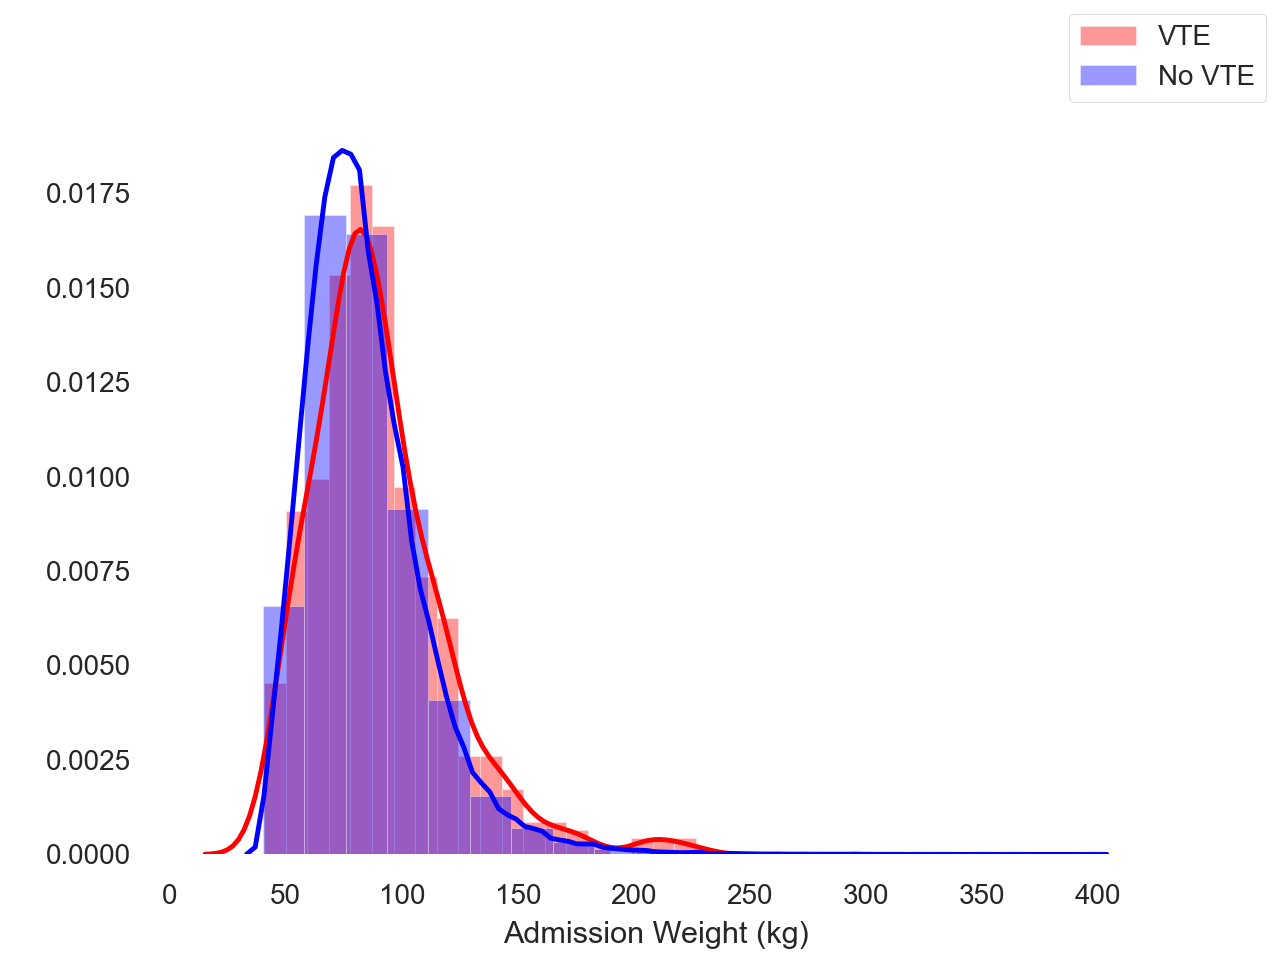

<IPython.core.display.Javascript object>


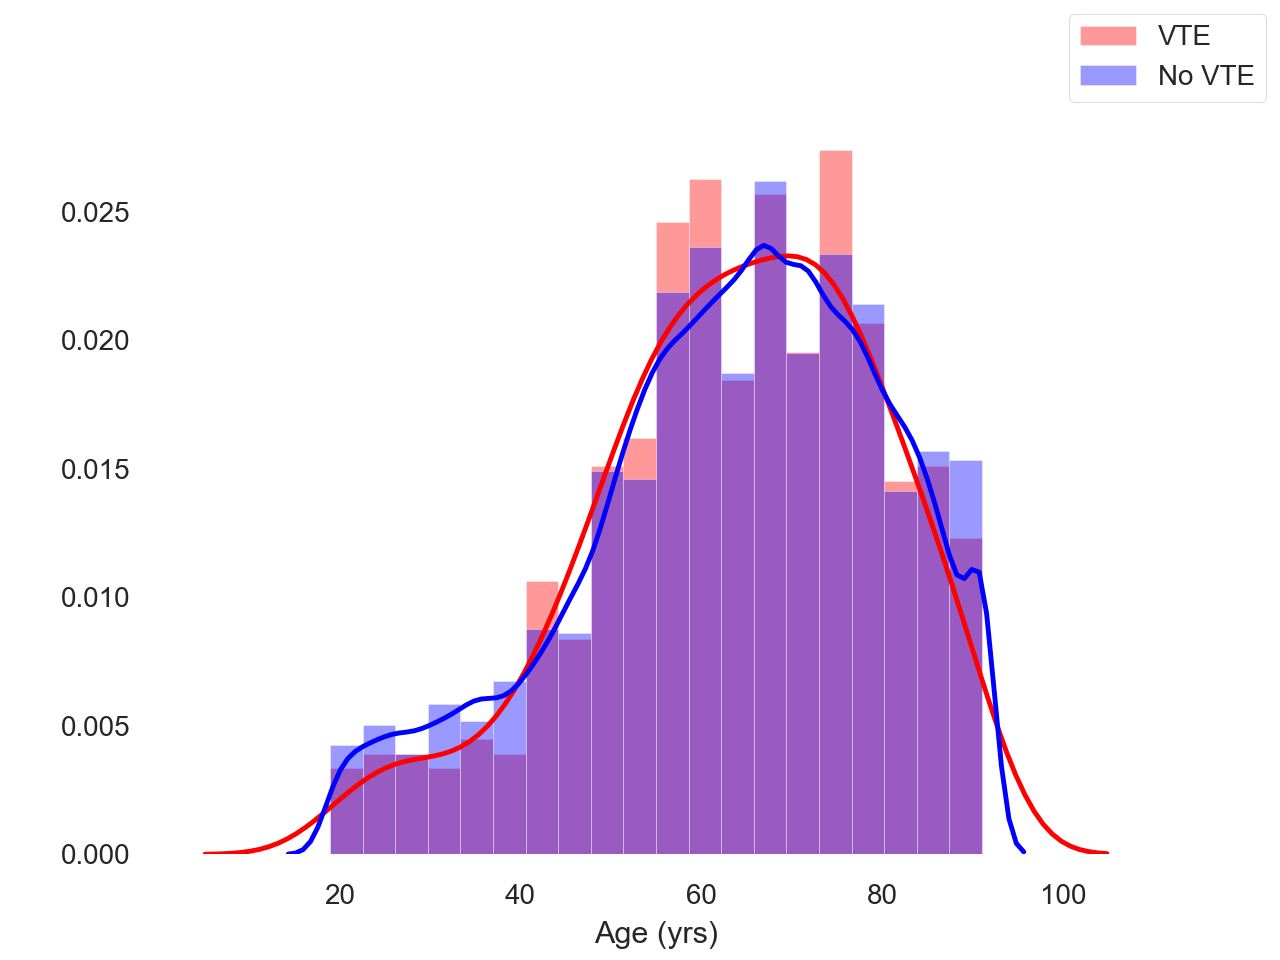

<IPython.core.display.Javascript object>


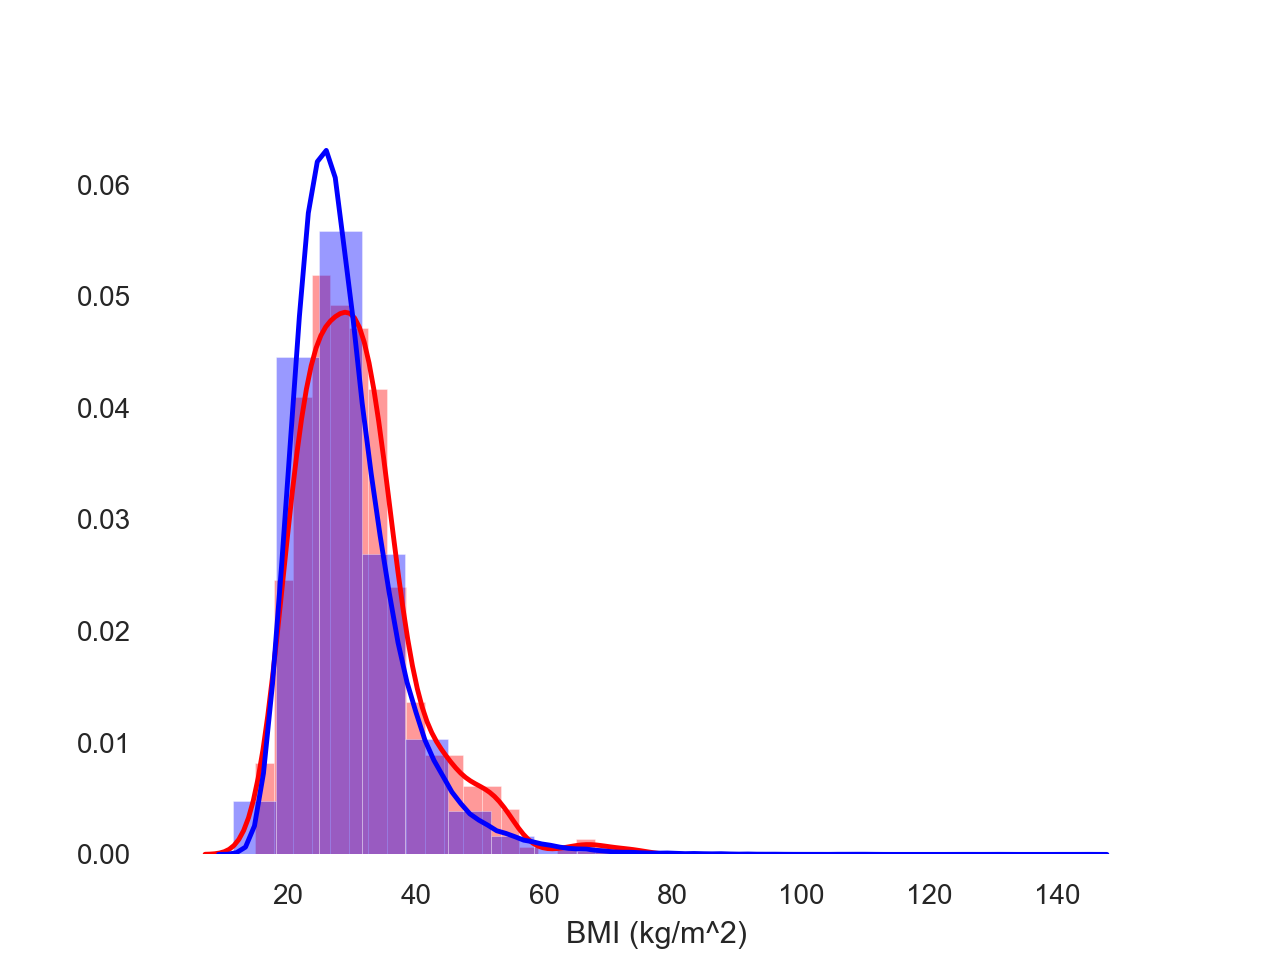

<IPython.core.display.Javascript object>


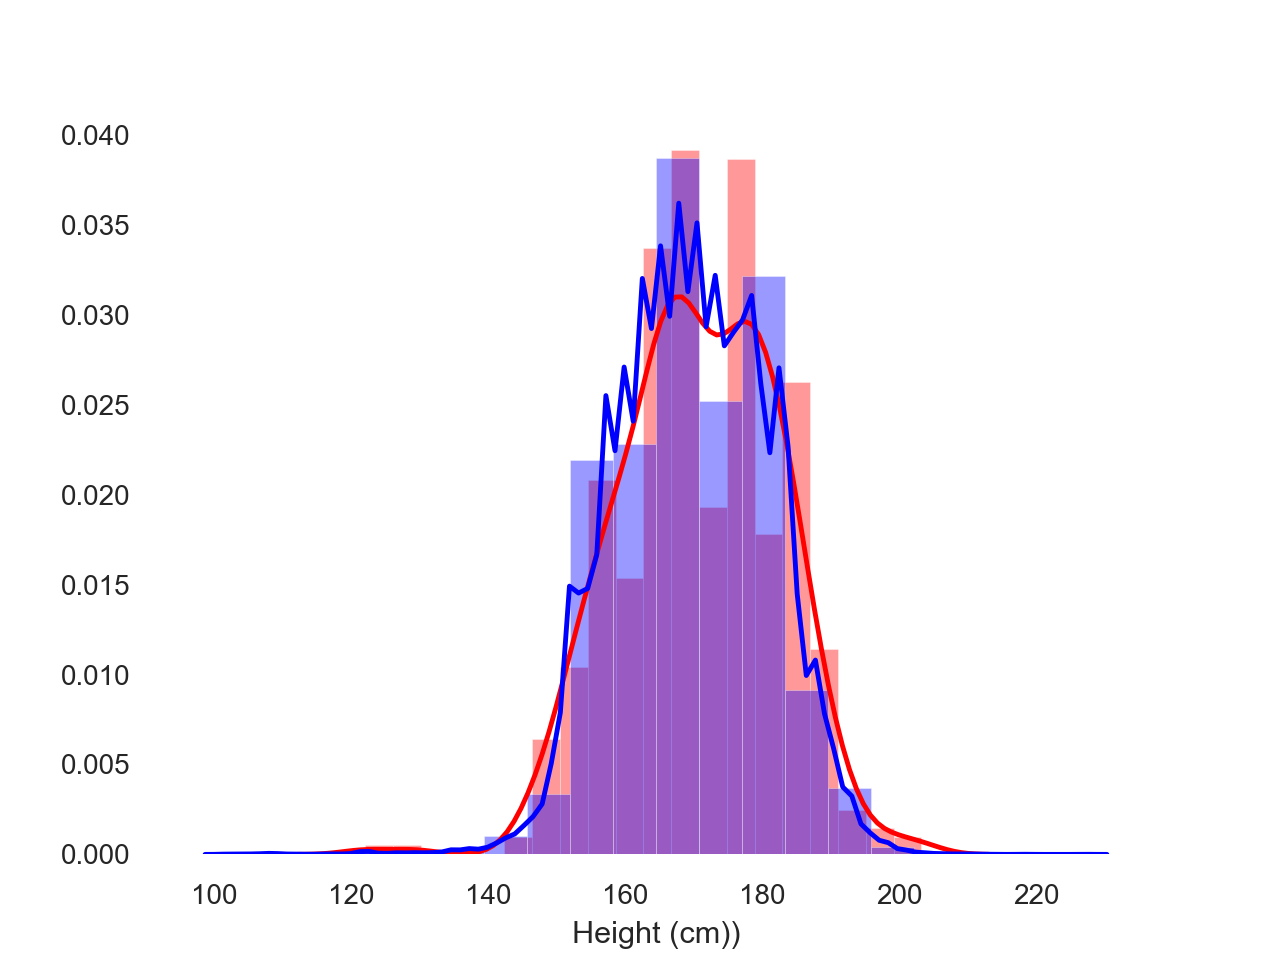

Text(0.5, 0, 'Height (cm))')

In [8]:
%matplotlib notebook
import seaborn as sns

fig = plt.figure()
VTE = sns.distplot(patient_pos['admissionweight'], color='red', bins=20)
noVTE = sns.distplot(patient_neg['admissionweight'], color='blue', bins=20)
plt.xlabel('Admission Weight (kg)')
fig.legend(labels=['VTE', 'No VTE'])

fig = plt.figure()
sns.distplot(patient_pos['age'], color='red', bins=20)
sns.distplot(patient_neg['age'], color='blue', bins=20)
fig.legend(labels=['VTE', 'No VTE'])
plt.xlabel('Age (yrs)')

fig = plt.figure()
sns.distplot(patient_pos['bmi'], color='red', bins=20)
sns.distplot(patient_neg['bmi'], color='blue', bins=20)
plt.xlabel('BMI (kg/m^2)')

fig = plt.figure()
sns.distplot(patient_pos['admissionheight'], color='red', bins=20)
sns.distplot(patient_neg['admissionheight'], color='blue', bins=20)
plt.xlabel('Height (cm))')

# Start defining X

In [9]:
Xy = patient[['label', 'patienthealthsystemstayid', 'age', 'admissionweight', 'admissionheight', 'bmi', 'gender_Female',
       'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown',
       'unitstaytype_admit', 'unitstaytype_readmit',
       'unitstaytype_stepdown/other', 'unitstaytype_transfer']]

# ApachePredVar

In [10]:
u_ptunitstayid = list(patient.index)
apachepredvar = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/data/over18_eicu/apachePredVar.csv')
apachepredvar = apachepredvar[apachepredvar['patientunitstayid'].isin(u_ptunitstayid)]

# Drop columns based on apachepredvar_allcols.html
apachepredvar = apachepredvar.drop(columns=['apachepredvarid', 'sicuday', 'saps3day1', 'saps3yesterday', 'saps3today', 'gender', \
                                    'teachtype', 'region', 'amilocation', 'bedcount', 'admitsource', 'graftcount', 'age', \
                                   'meds', 'diedinhospital', 'electivesurgery', 'readmit', 'managementsystem', 'var03hspxlos', \
                                   'ejectfx', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',  'day1pao2', 'day1fio2', \
                                           'dischargelocation', 'pao2', 'fio2']) # pao2 and fio2 are <0 too frequently
apachepredvar = apachepredvar.drop(columns=['admitdiagnosis'])
apachepredvar = apachepredvar[apachepredvar['verbal']!=-1] # Get rid of missing data
apachepredvar.set_index('patientunitstayid')

,verbal,motor,eyes,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,activetx,ima,midur,ventday1,oobventday1,oobintubday1,diabetes,creatinine,visitnumber
patientunitstayid,,,,,,,,,,,,,,,,,,,,
141168,5,6,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.30,1
141194,4,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.51,1
141197,5,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.00,1
141203,1,3,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0.56,1
141208,5,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353201,5,6,3,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,-1.00,3
3353216,1,5,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0.73,1
3353235,5,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.00,1


In [11]:
Xy.shape

(159754, 17)

In [12]:
apachepredvar.shape

(148328, 21)

In [13]:
Xy2 = Xy.merge(apachepredvar, how='right', left_on='patientunitstayid', right_on='patientunitstayid')

In [14]:
Xy2.shape

(148328, 38)

# Admissiondx

In [16]:
admissiondx.head()

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


<IPython.core.display.Javascript object>


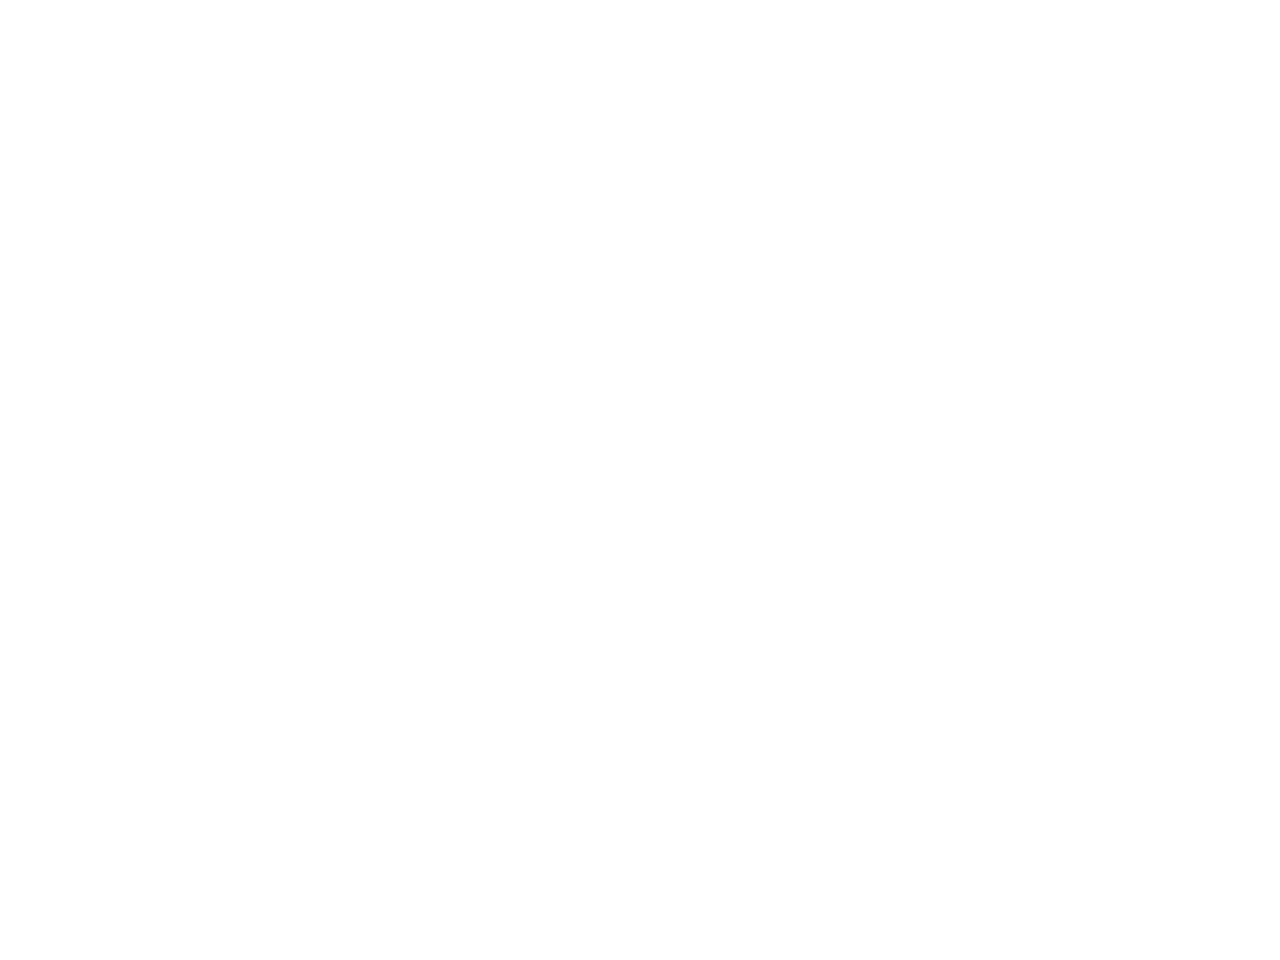

<IPython.core.display.Javascript object>


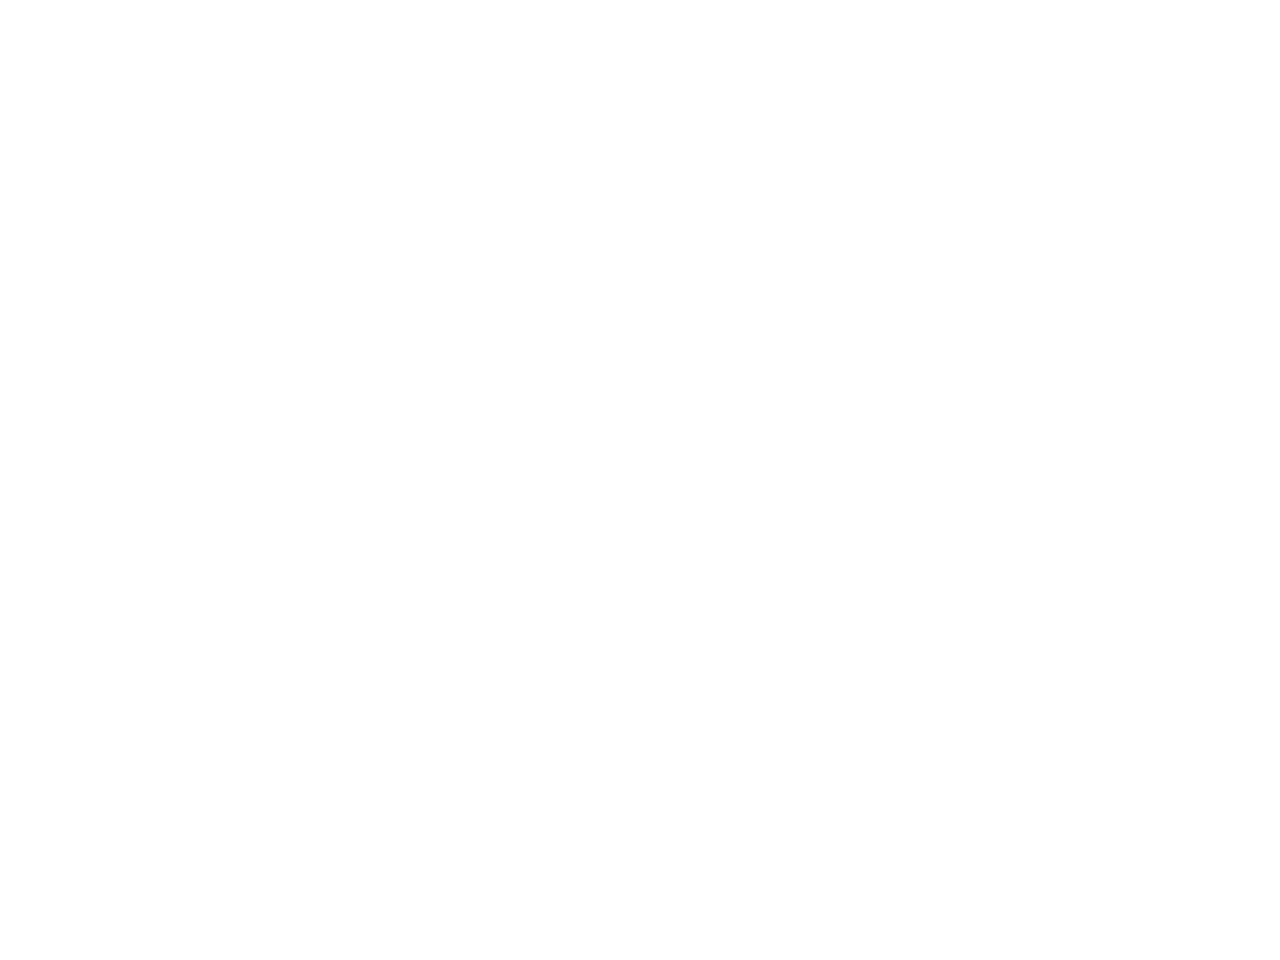

<IPython.core.display.Javascript object>


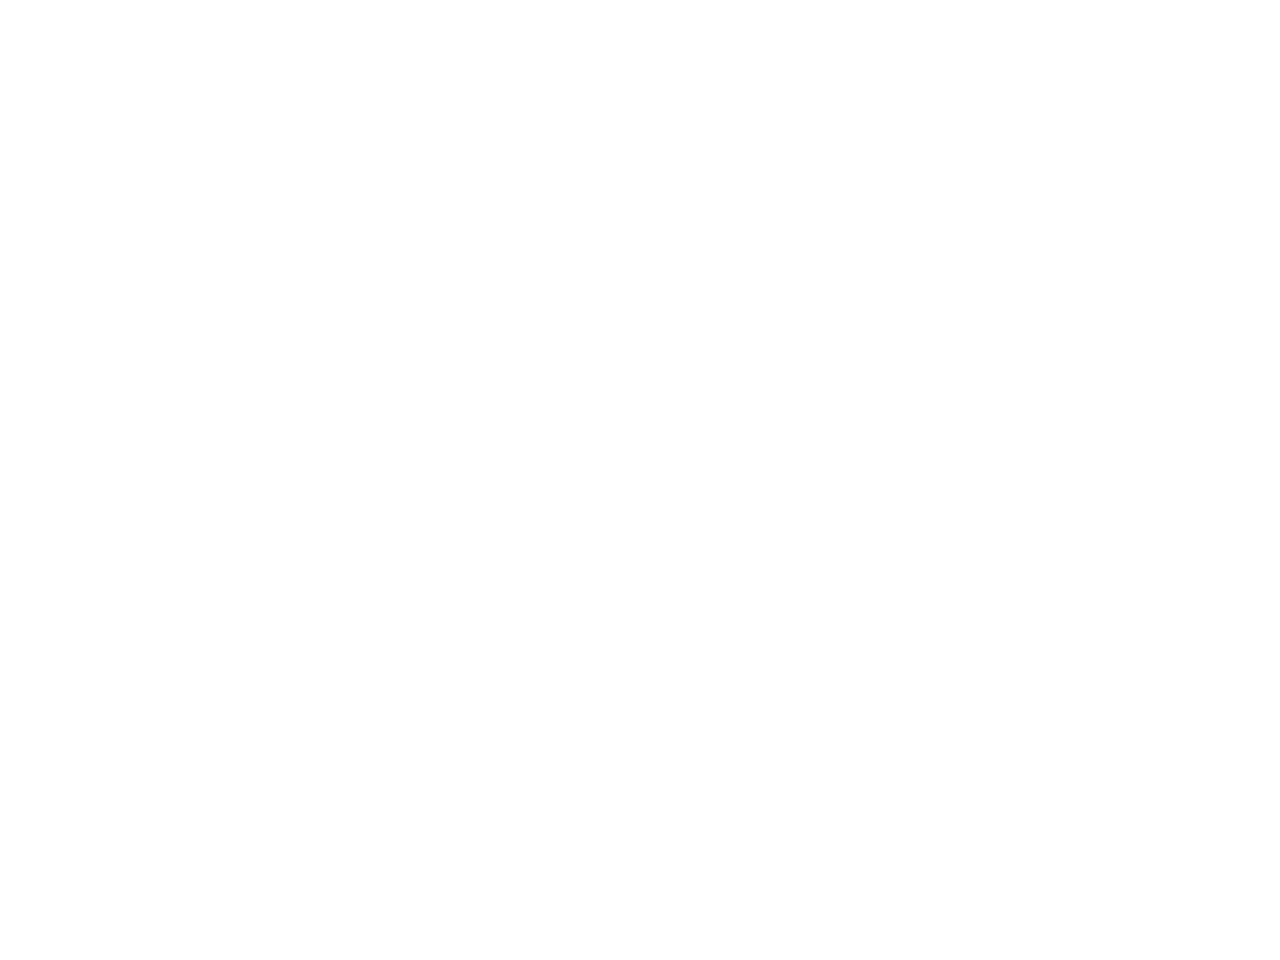

<IPython.core.display.Javascript object>


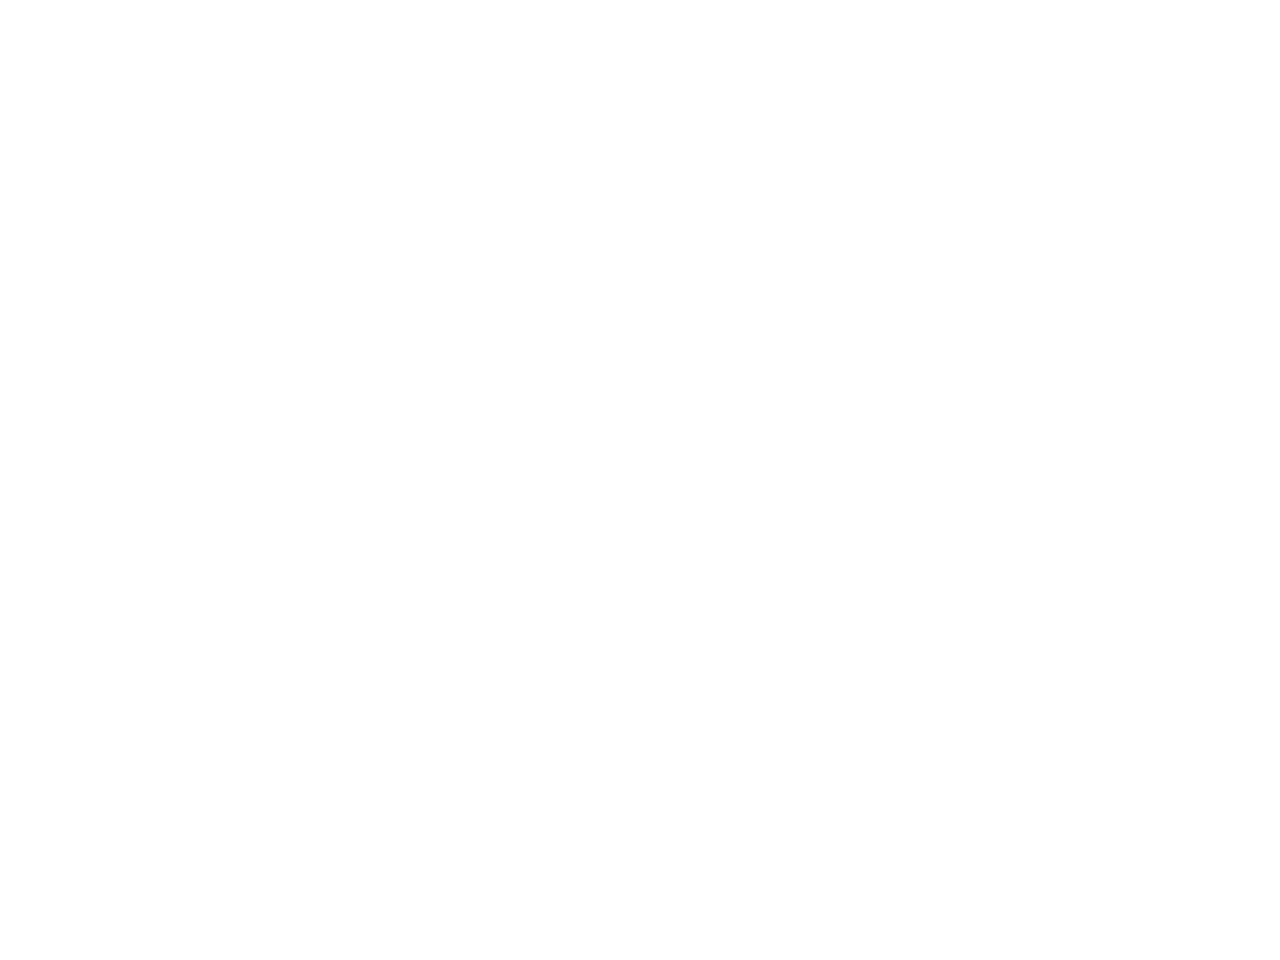

<IPython.core.display.Javascript object>


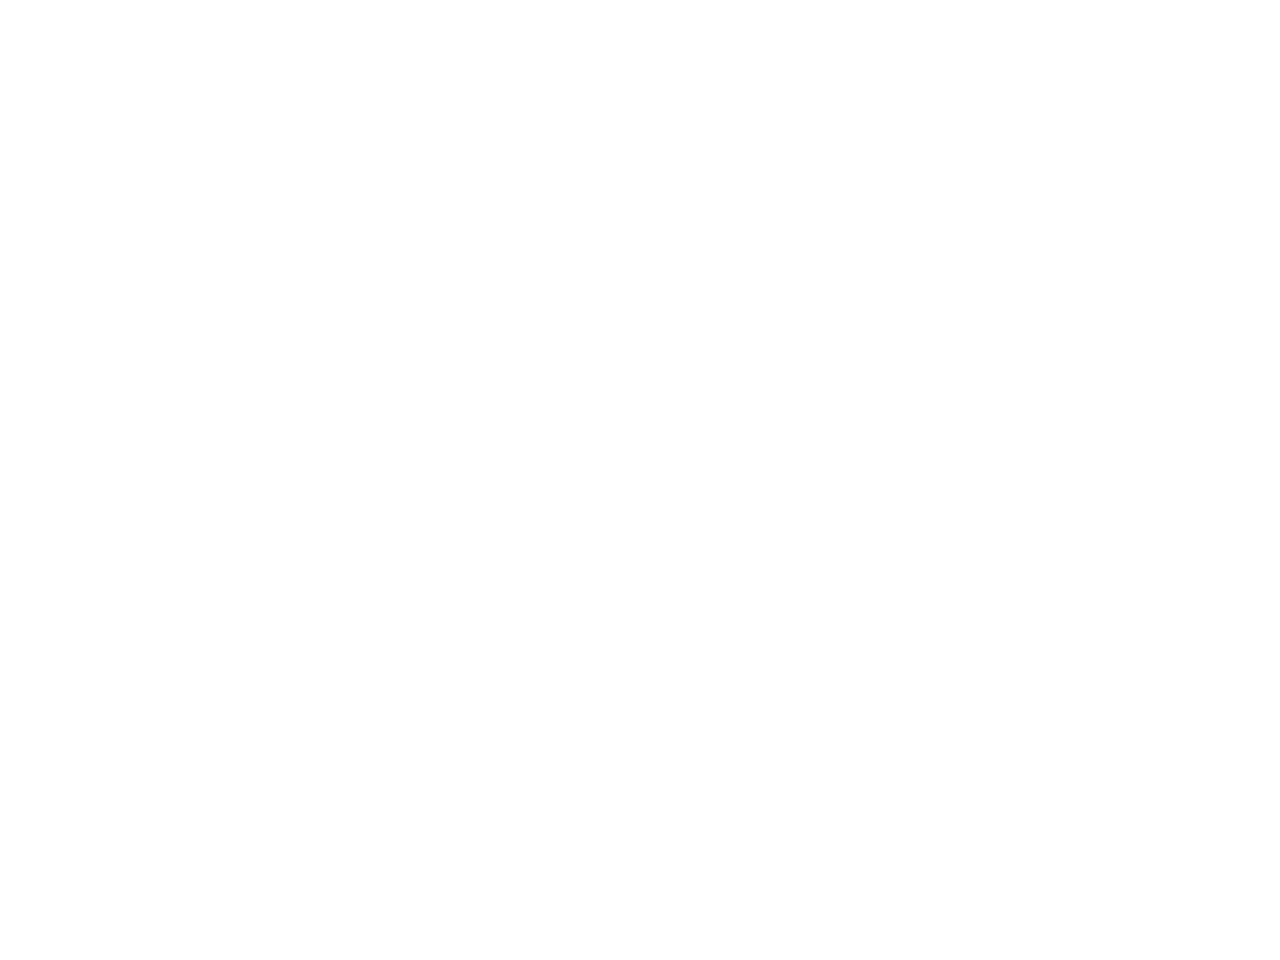

<IPython.core.display.Javascript object>


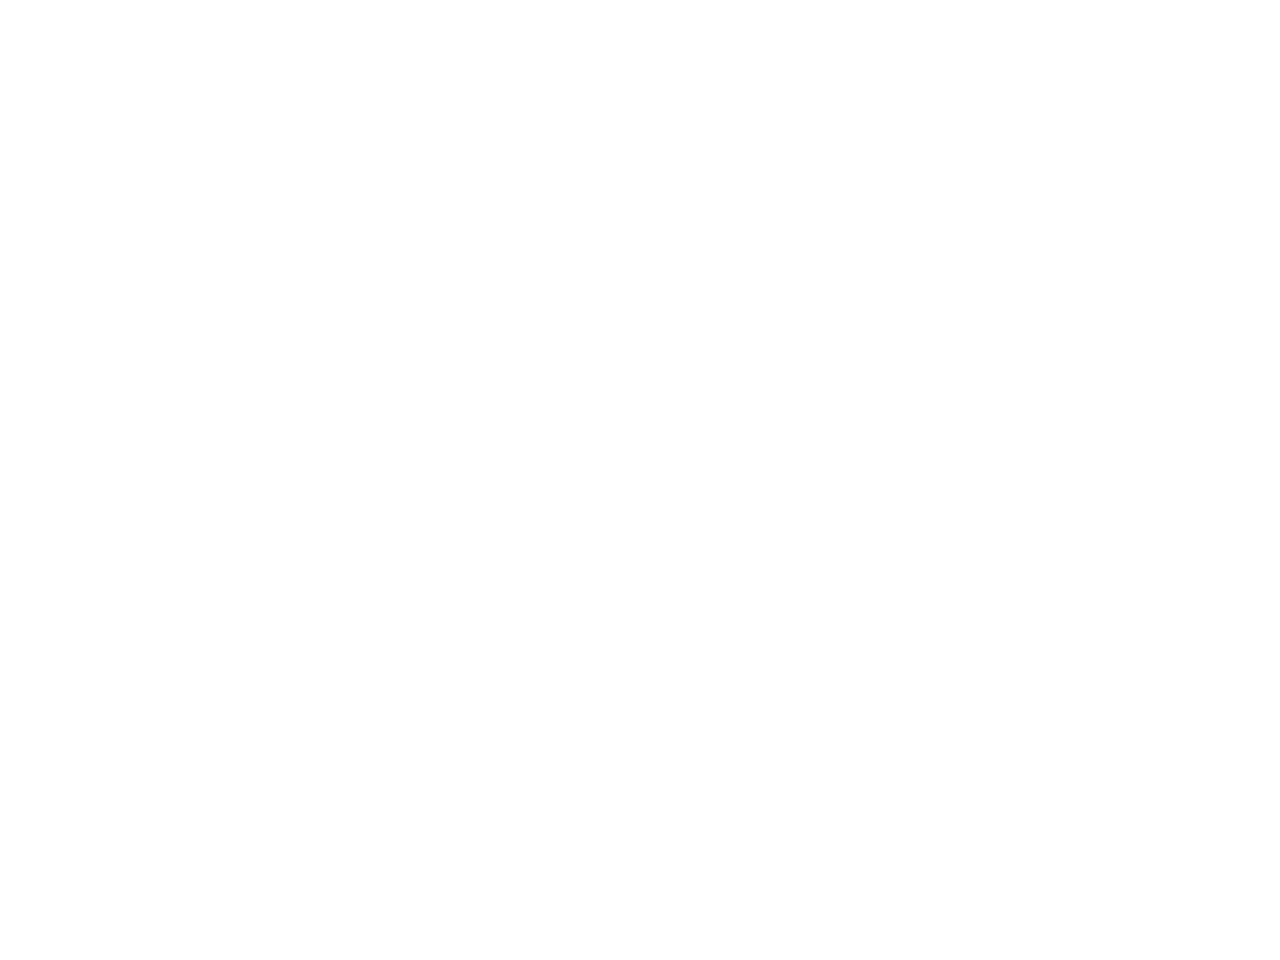

<IPython.core.display.Javascript object>


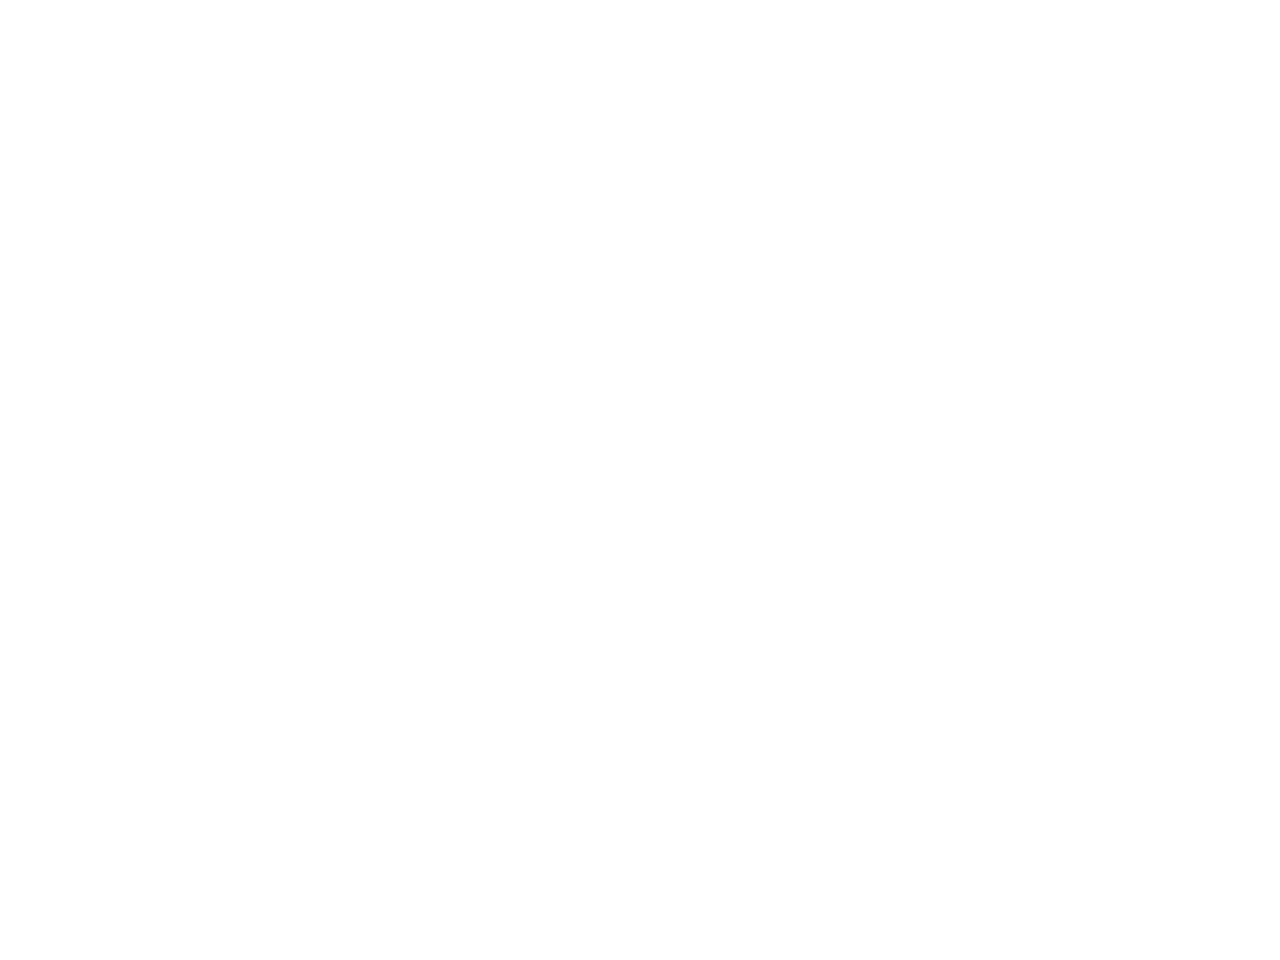

<IPython.core.display.Javascript object>


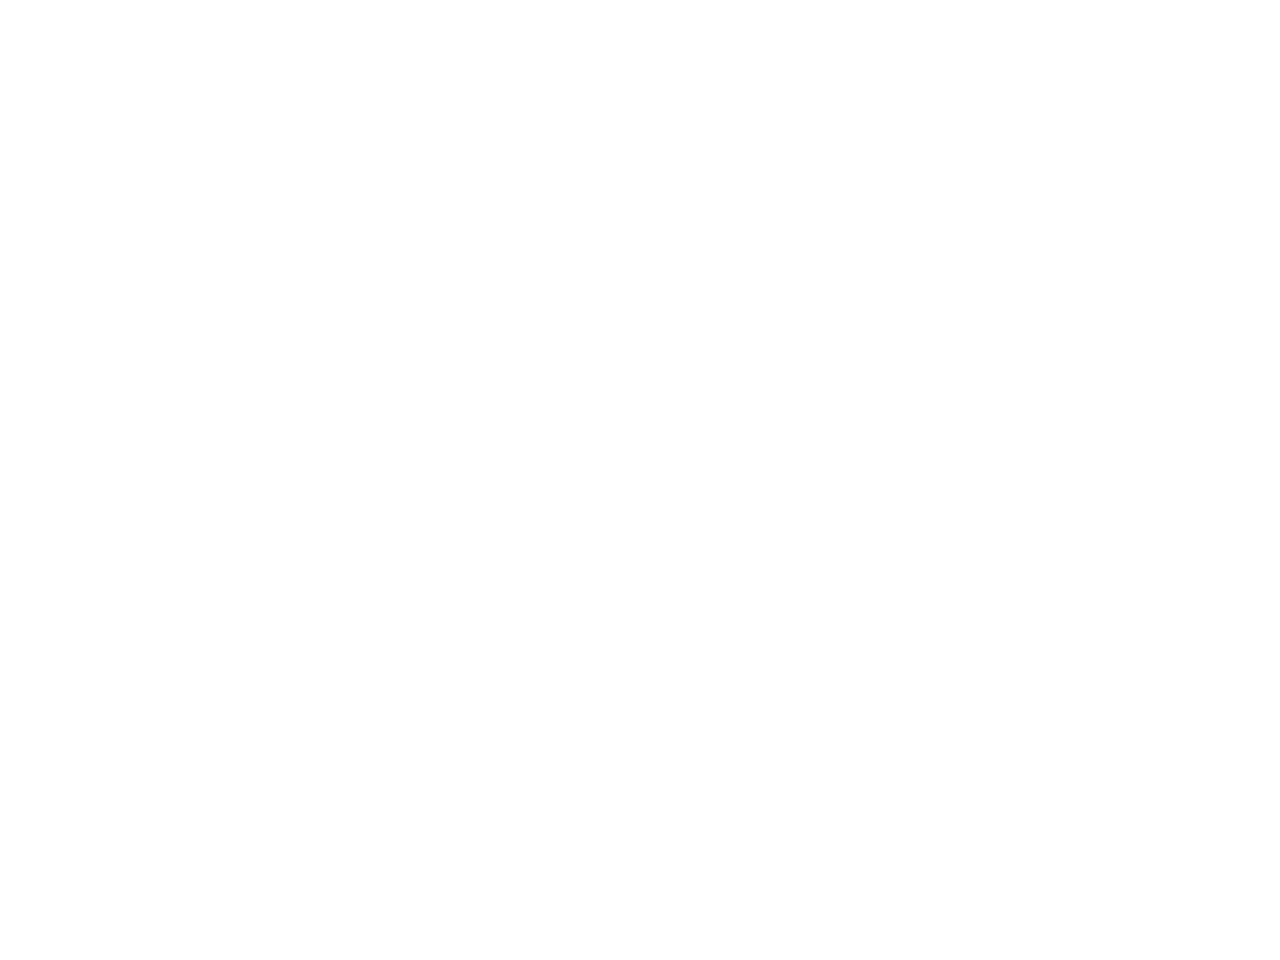

<IPython.core.display.Javascript object>


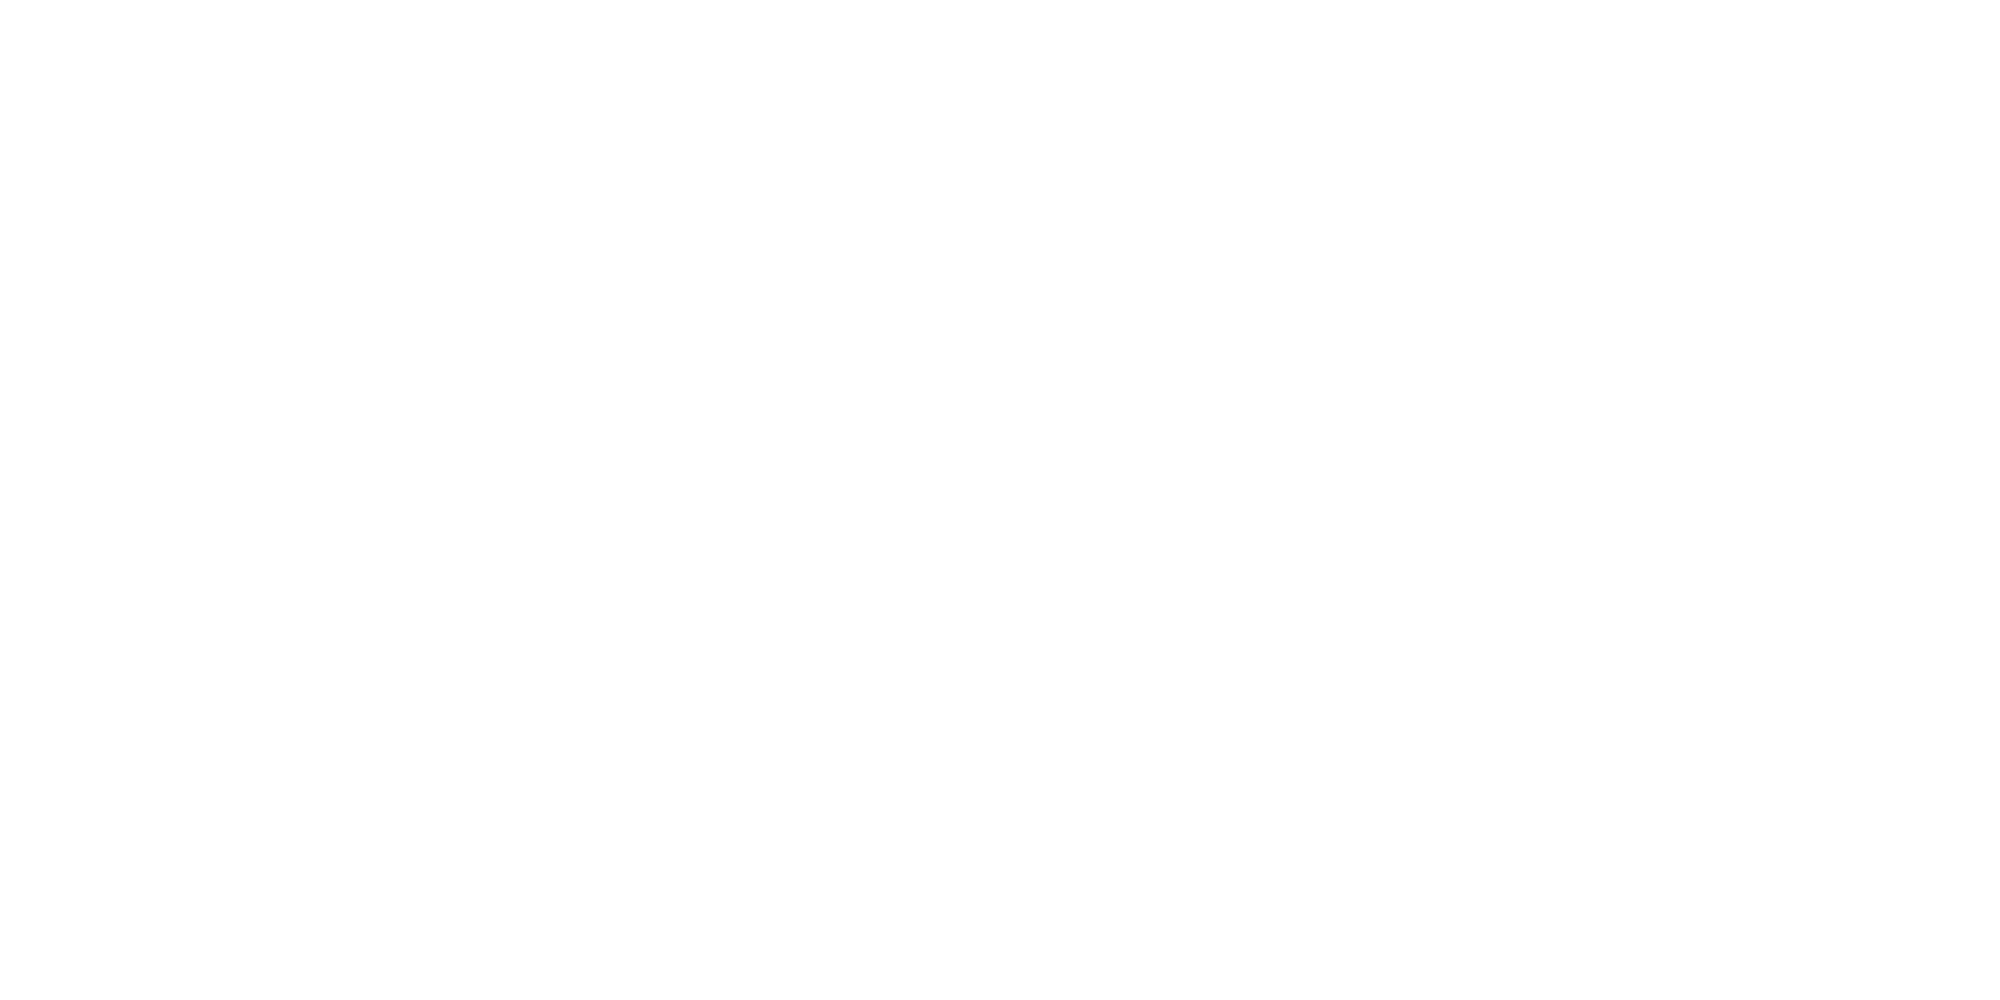

<IPython.core.display.Javascript object>


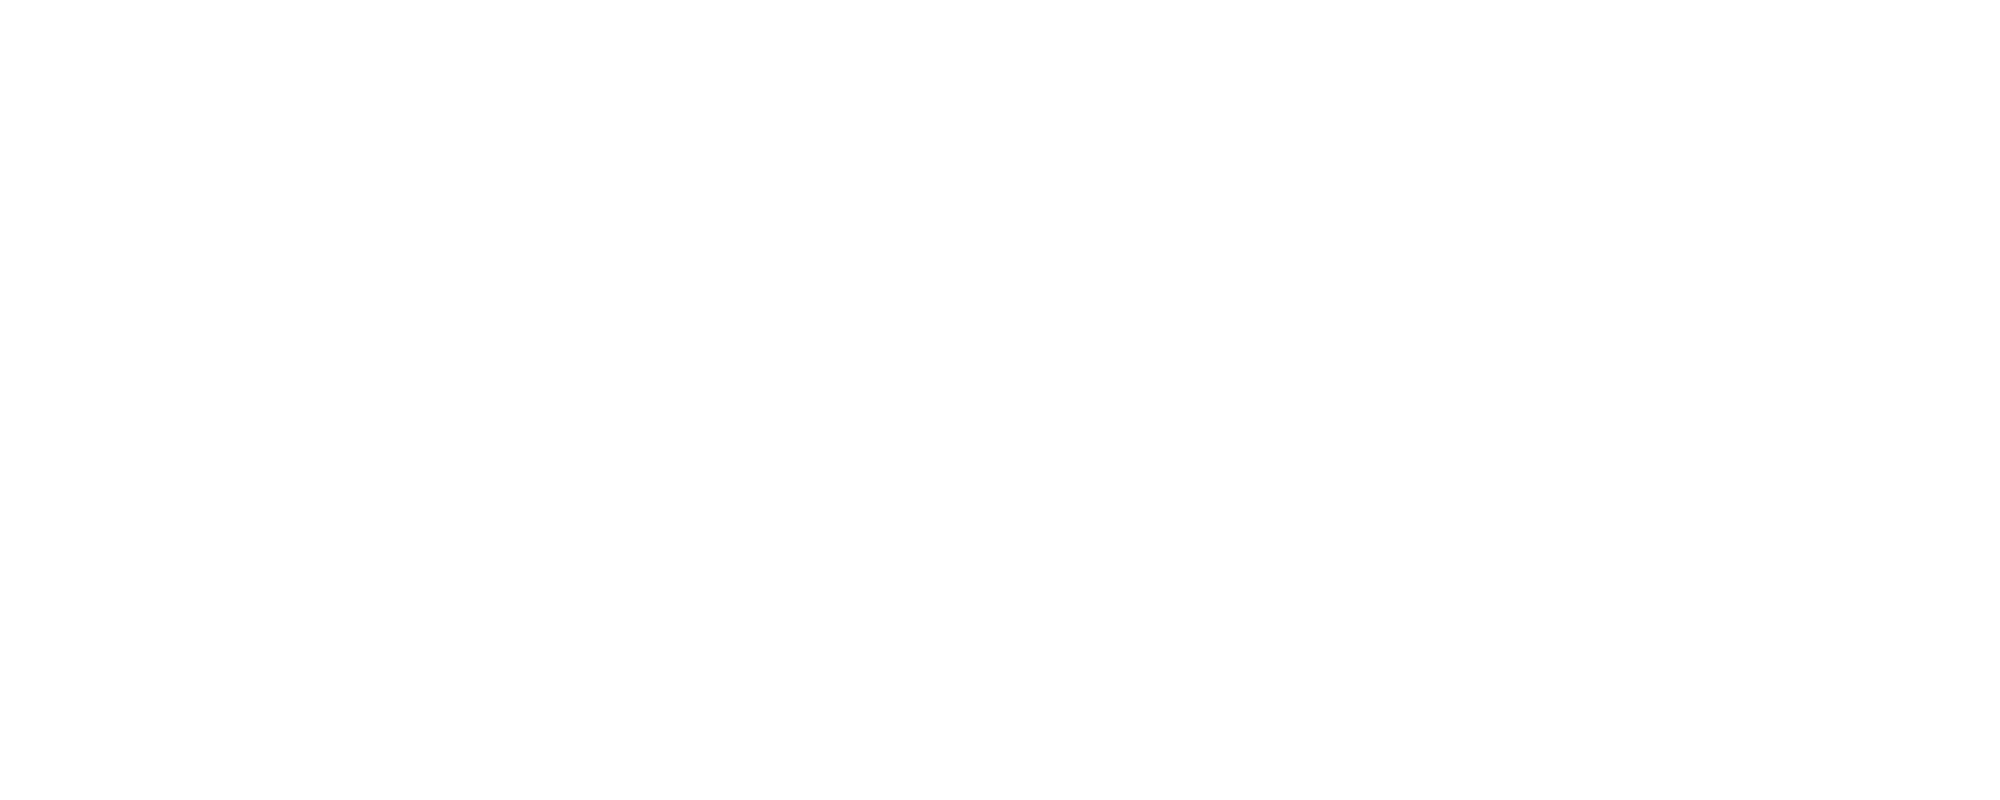

<IPython.core.display.Javascript object>


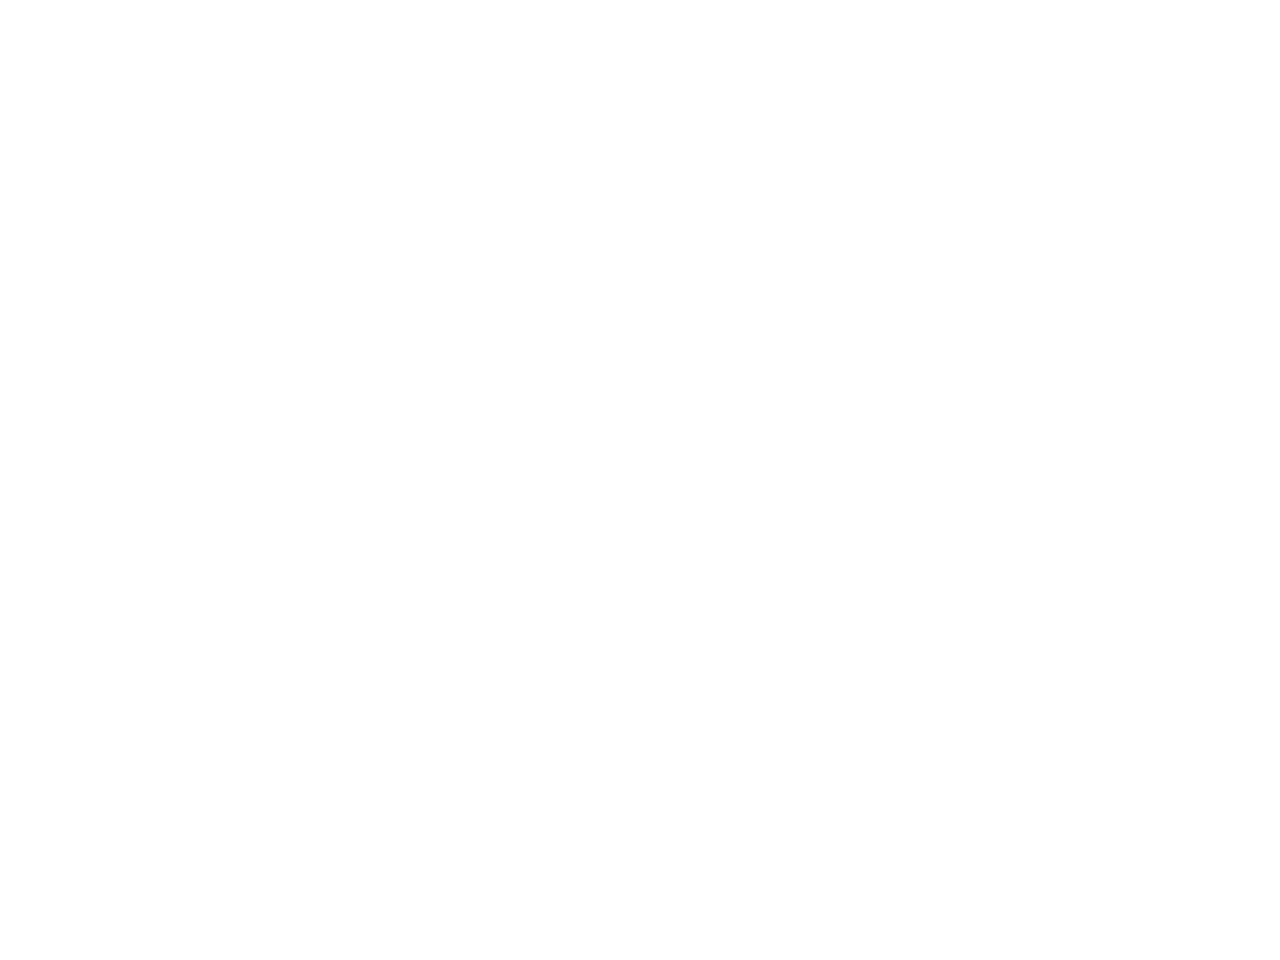

<IPython.core.display.Javascript object>


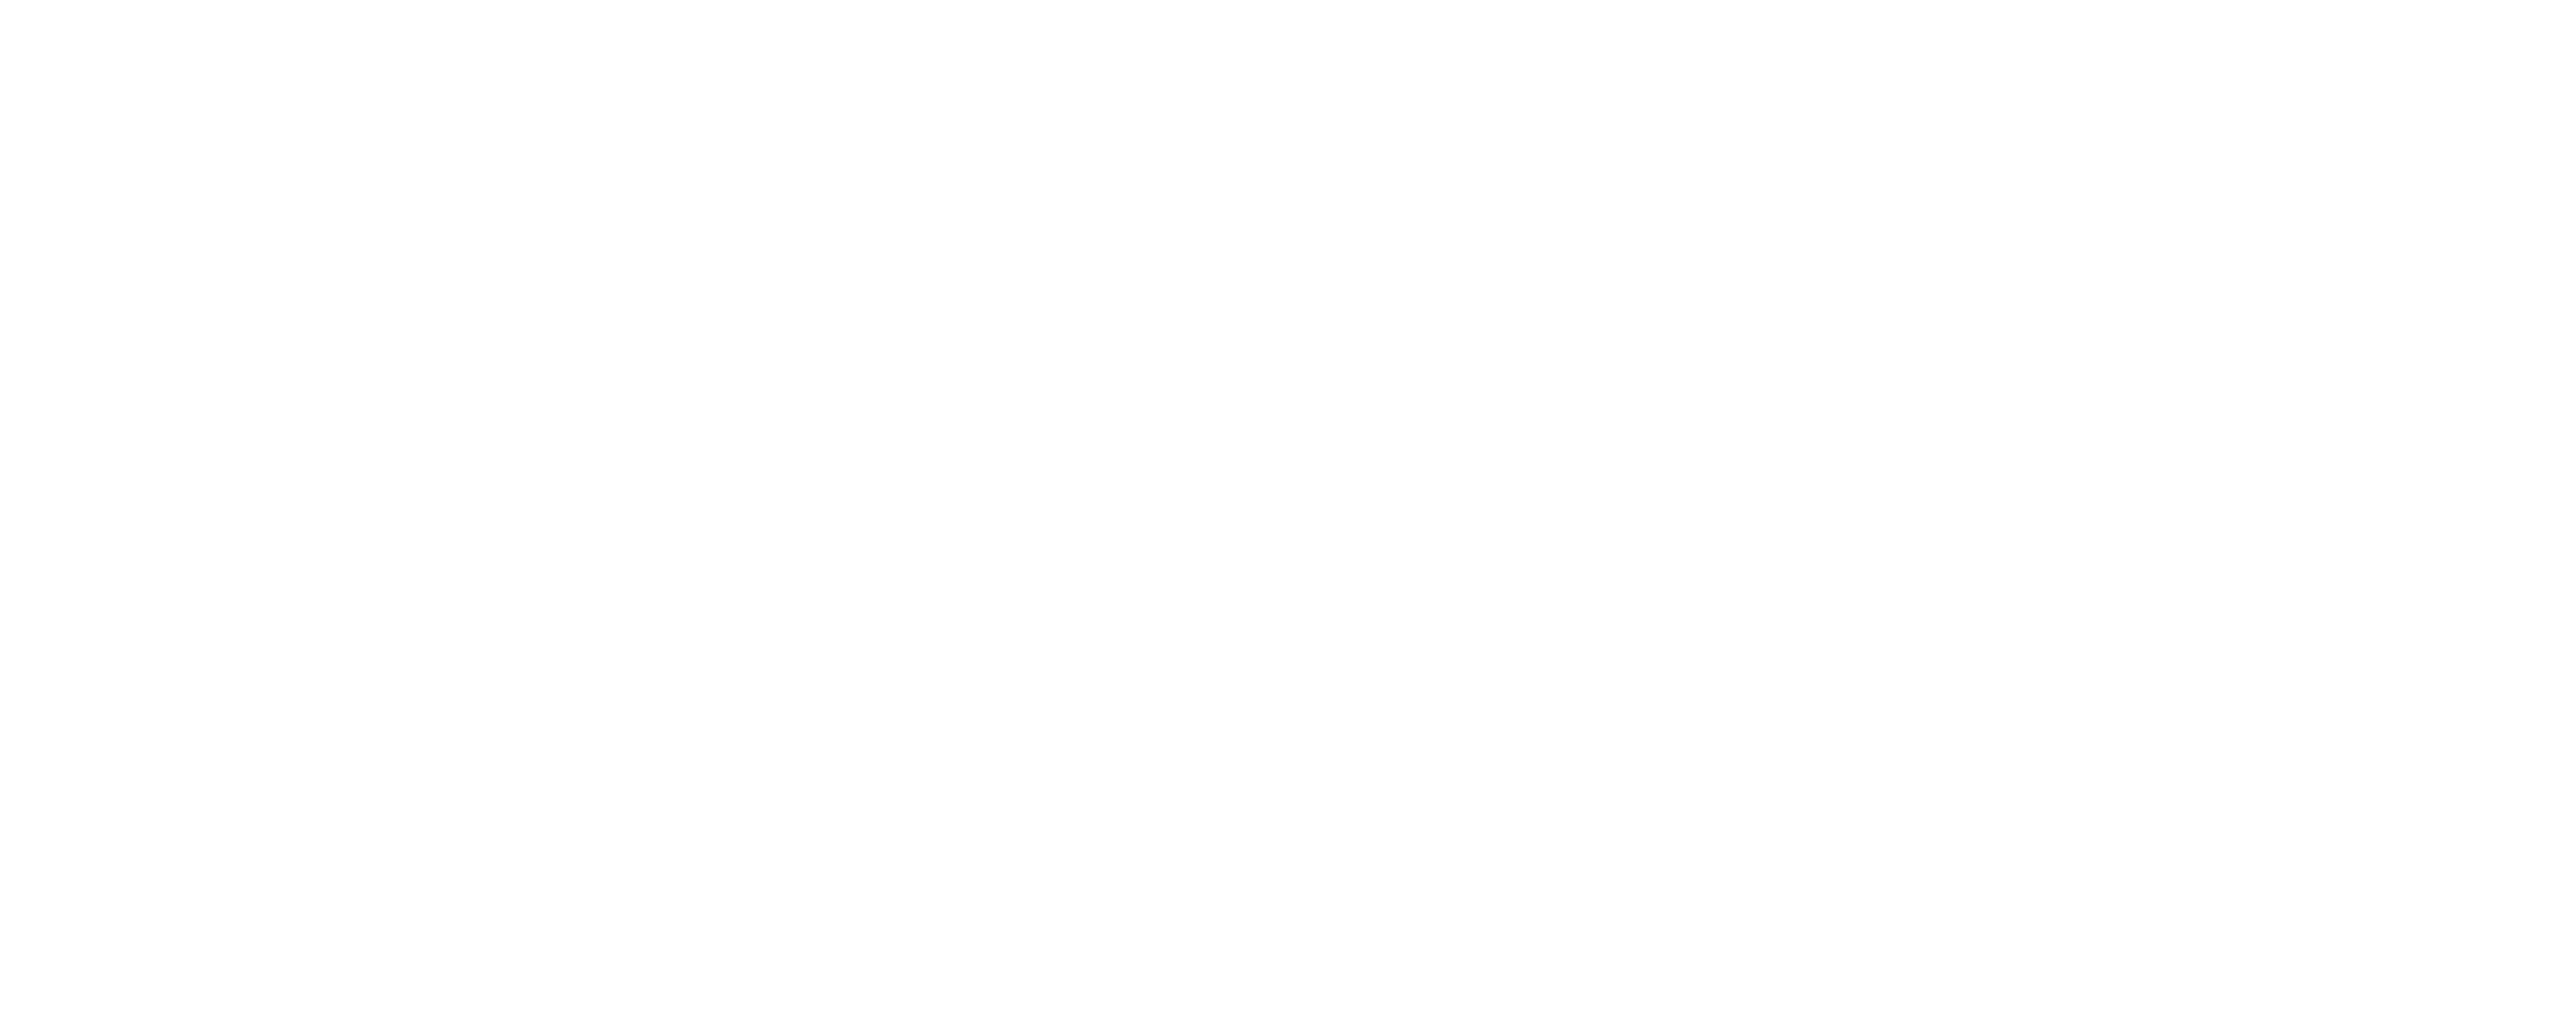

<IPython.core.display.Javascript object>


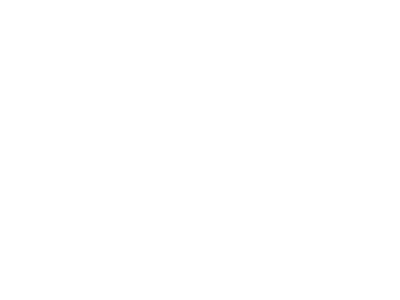

<IPython.core.display.Javascript object>


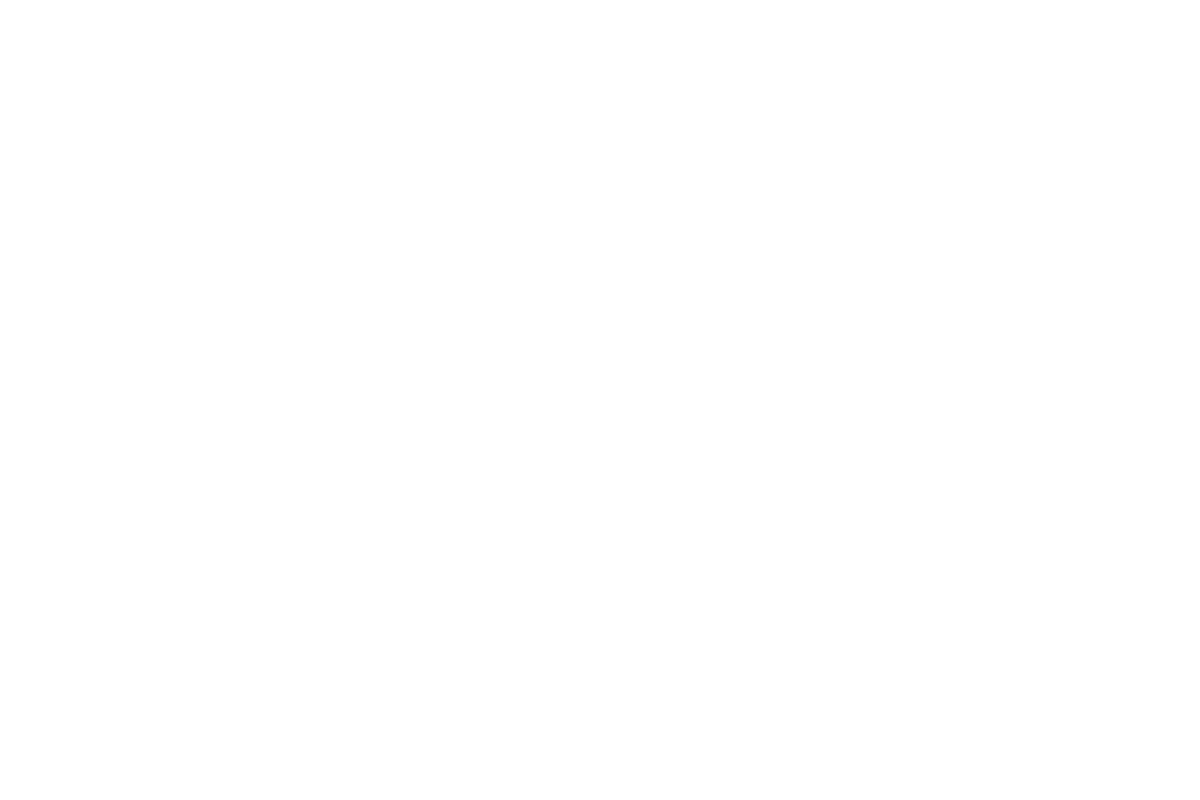

<IPython.core.display.Javascript object>


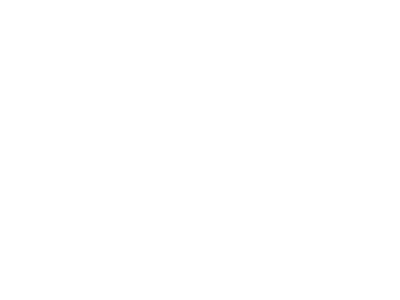

<IPython.core.display.Javascript object>


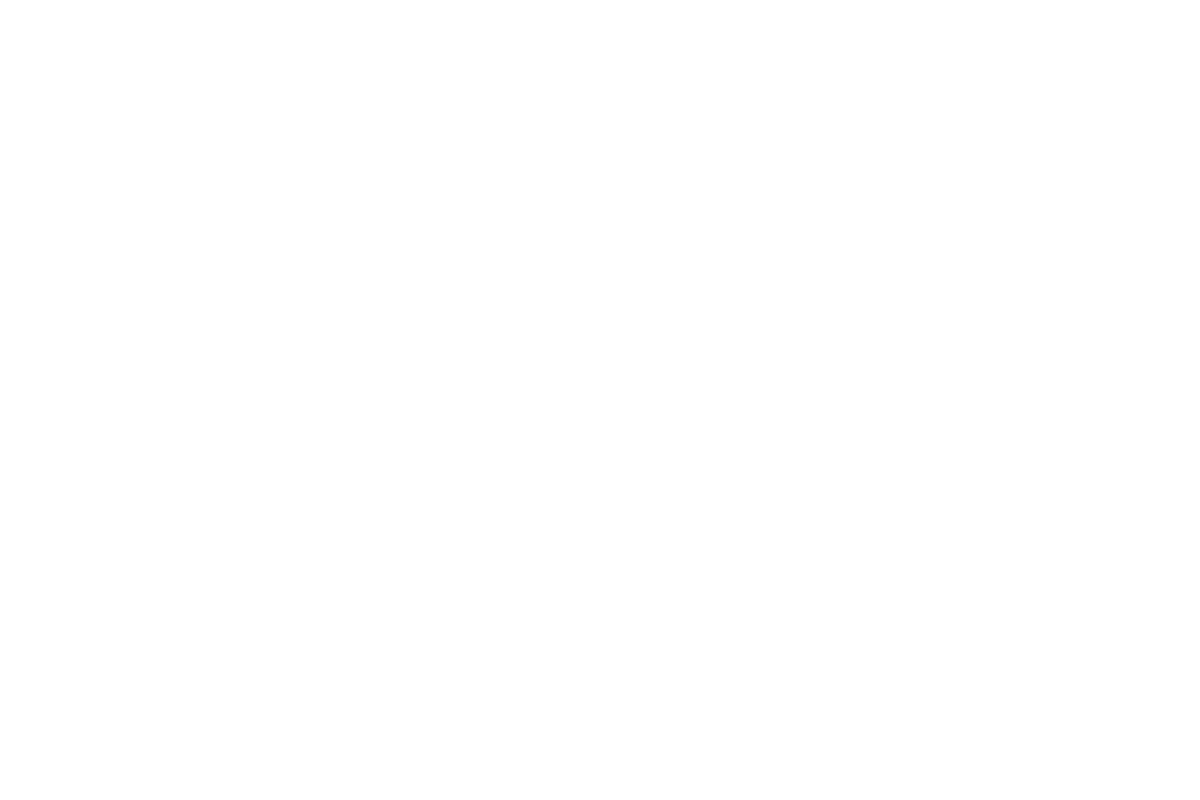

<IPython.core.display.Javascript object>


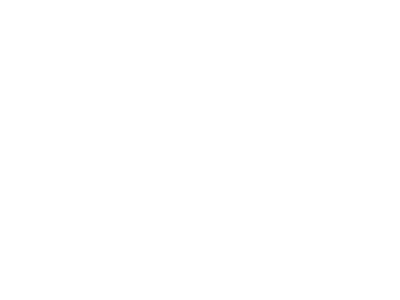

<IPython.core.display.Javascript object>


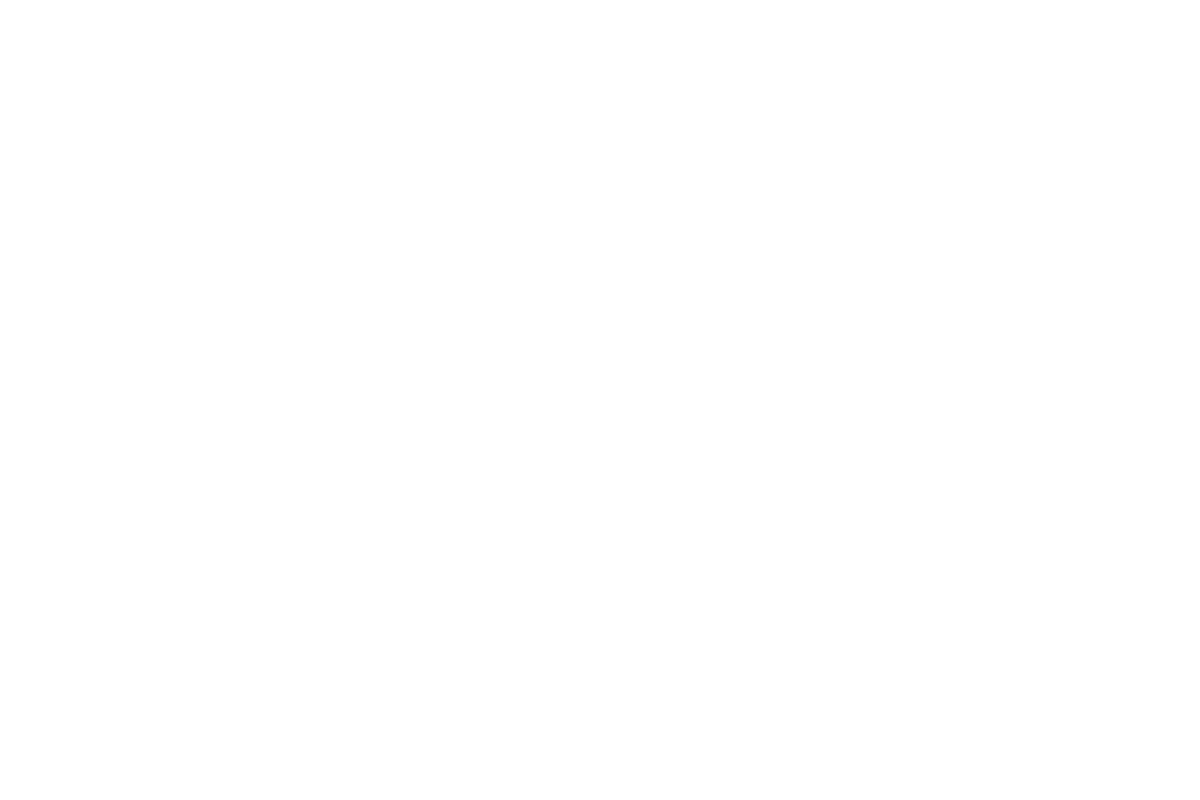

<IPython.core.display.Javascript object>


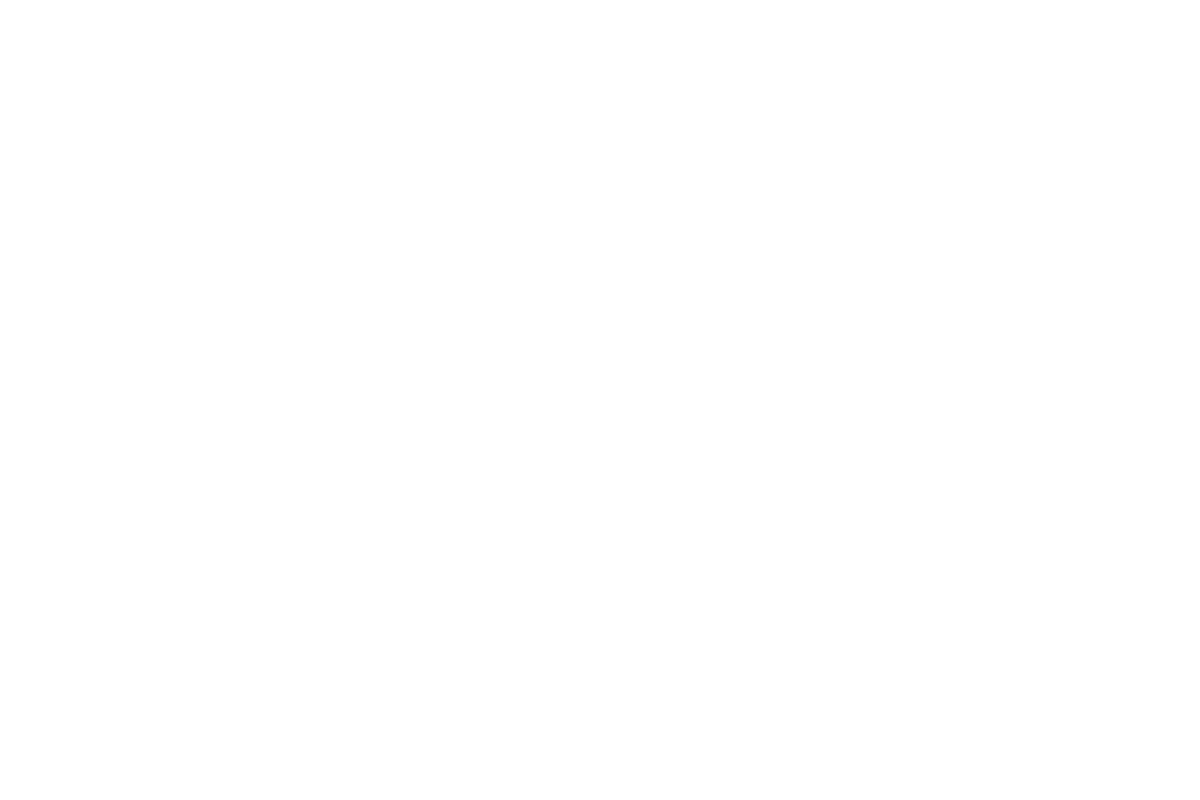

<IPython.core.display.Javascript object>


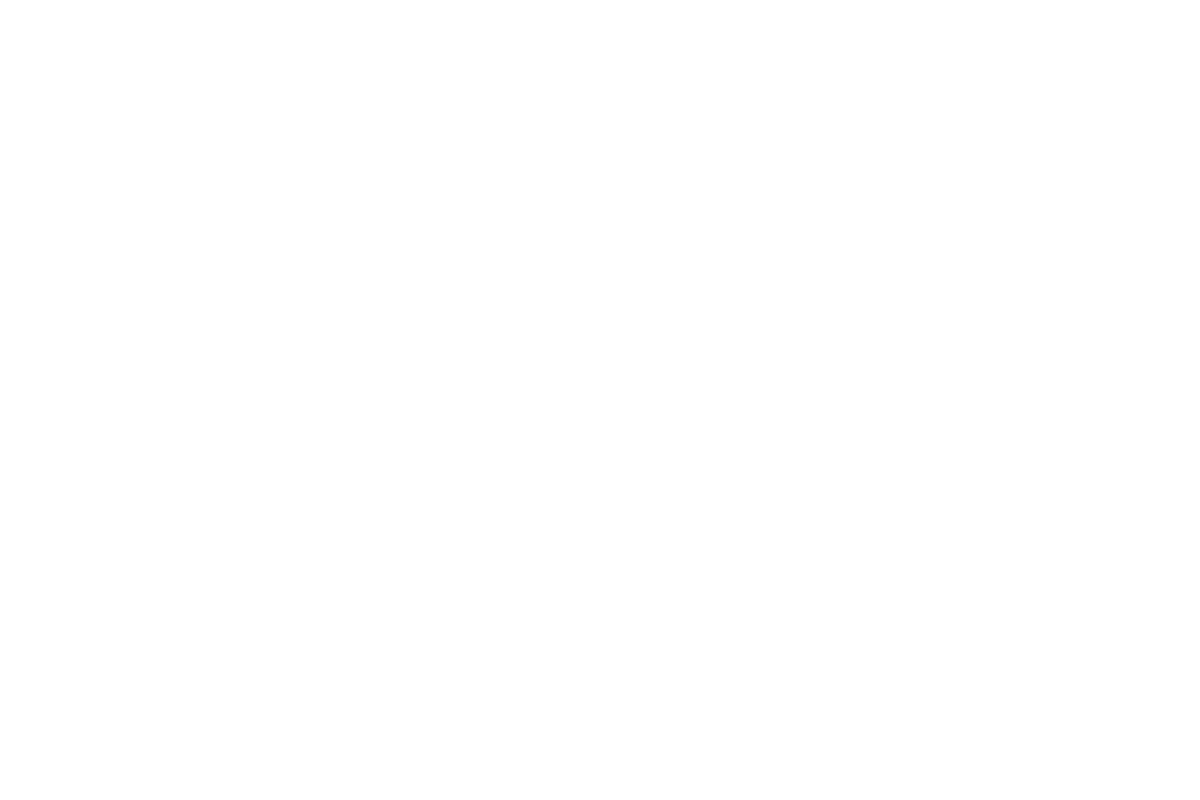

<IPython.core.display.Javascript object>


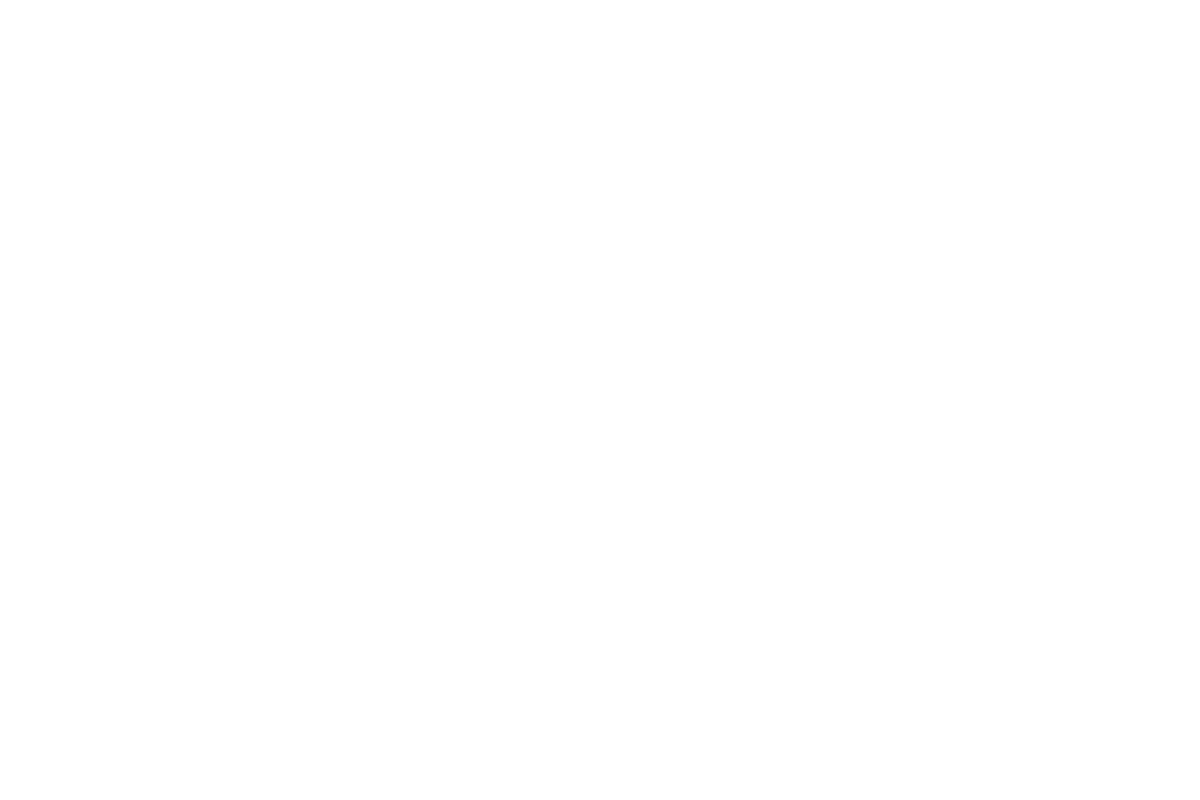

<IPython.core.display.Javascript object>


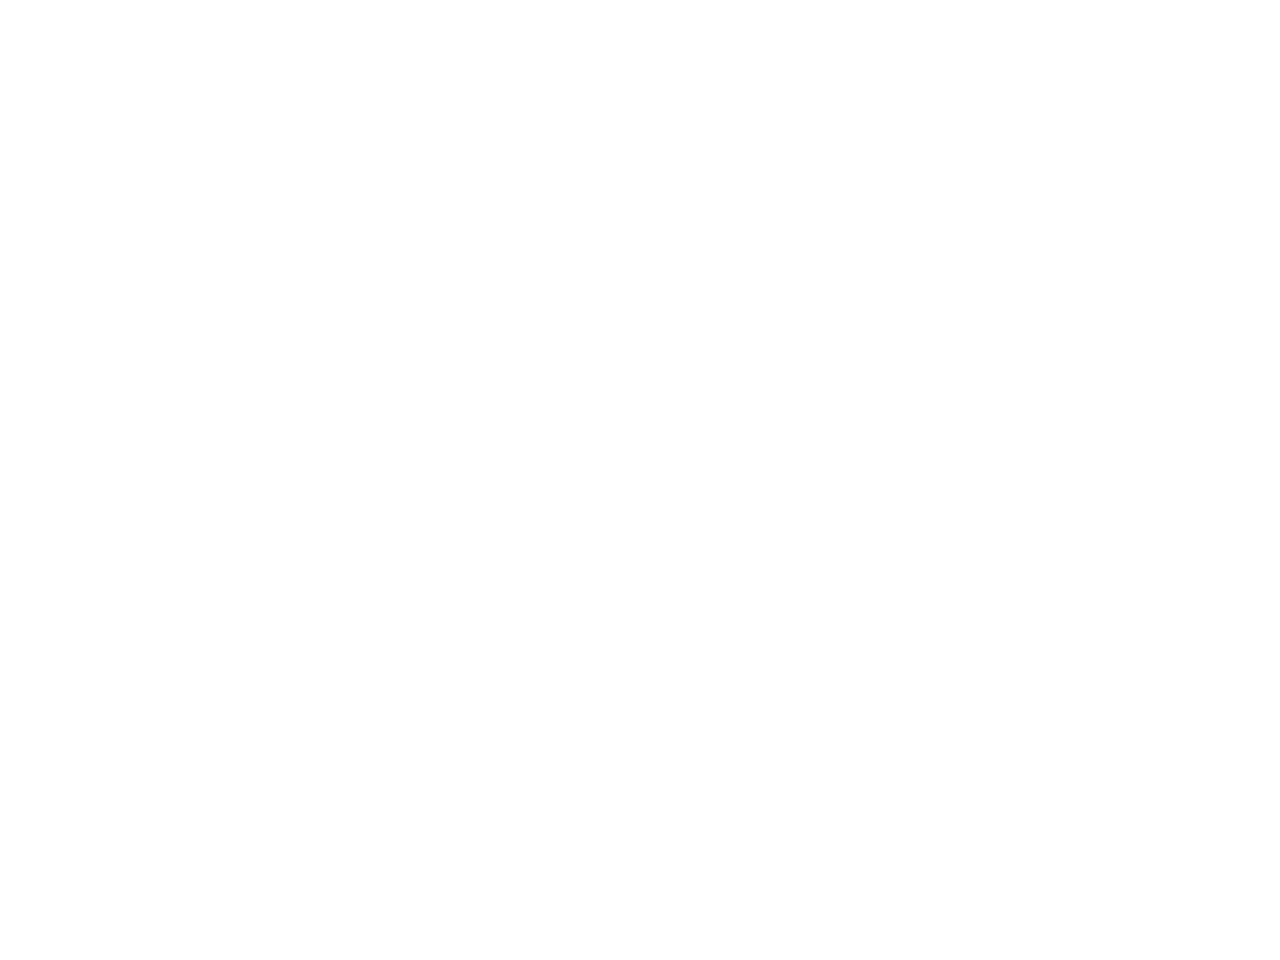

<IPython.core.display.Javascript object>


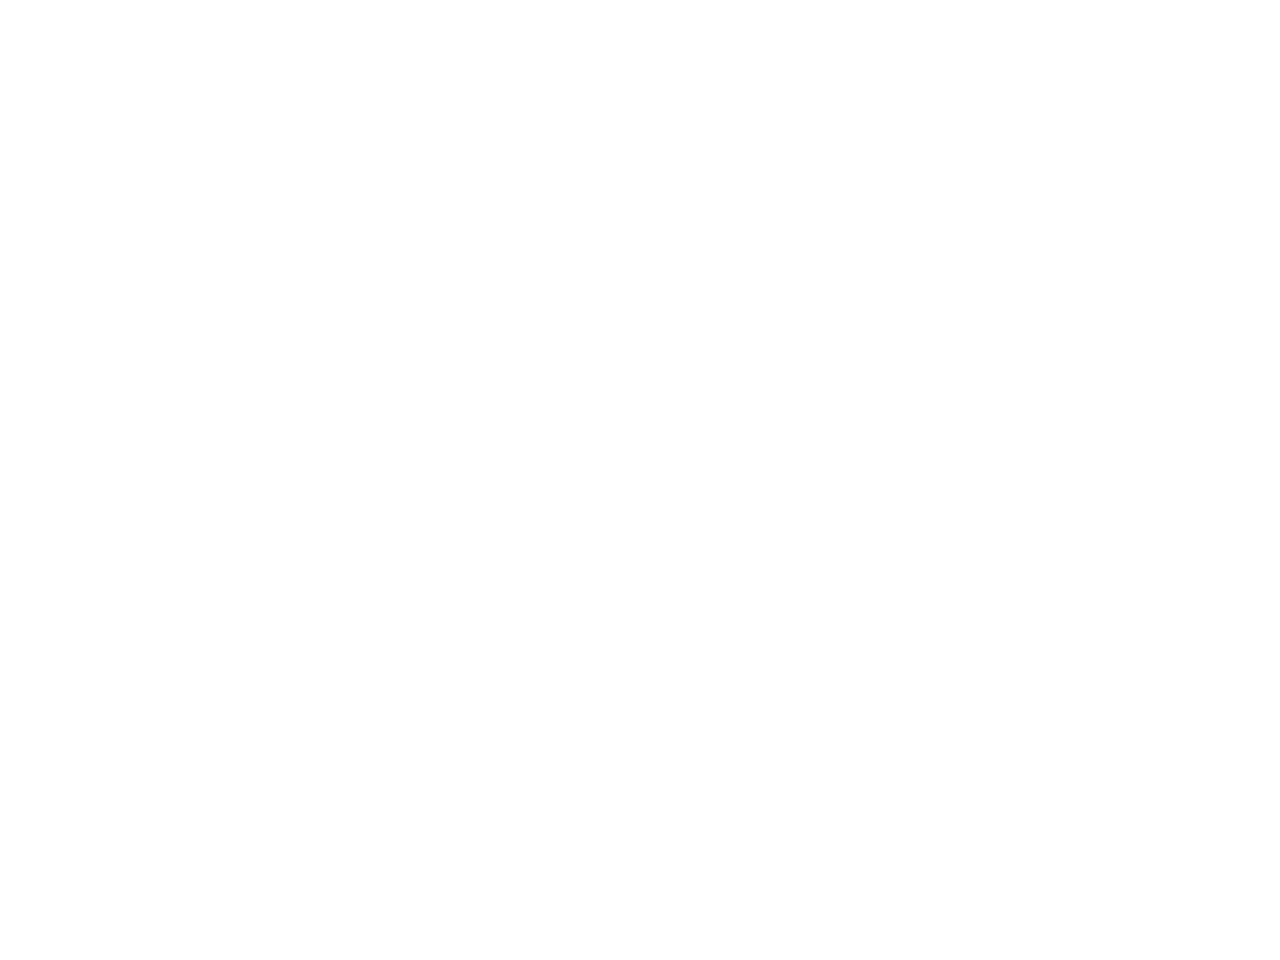

<IPython.core.display.Javascript object>


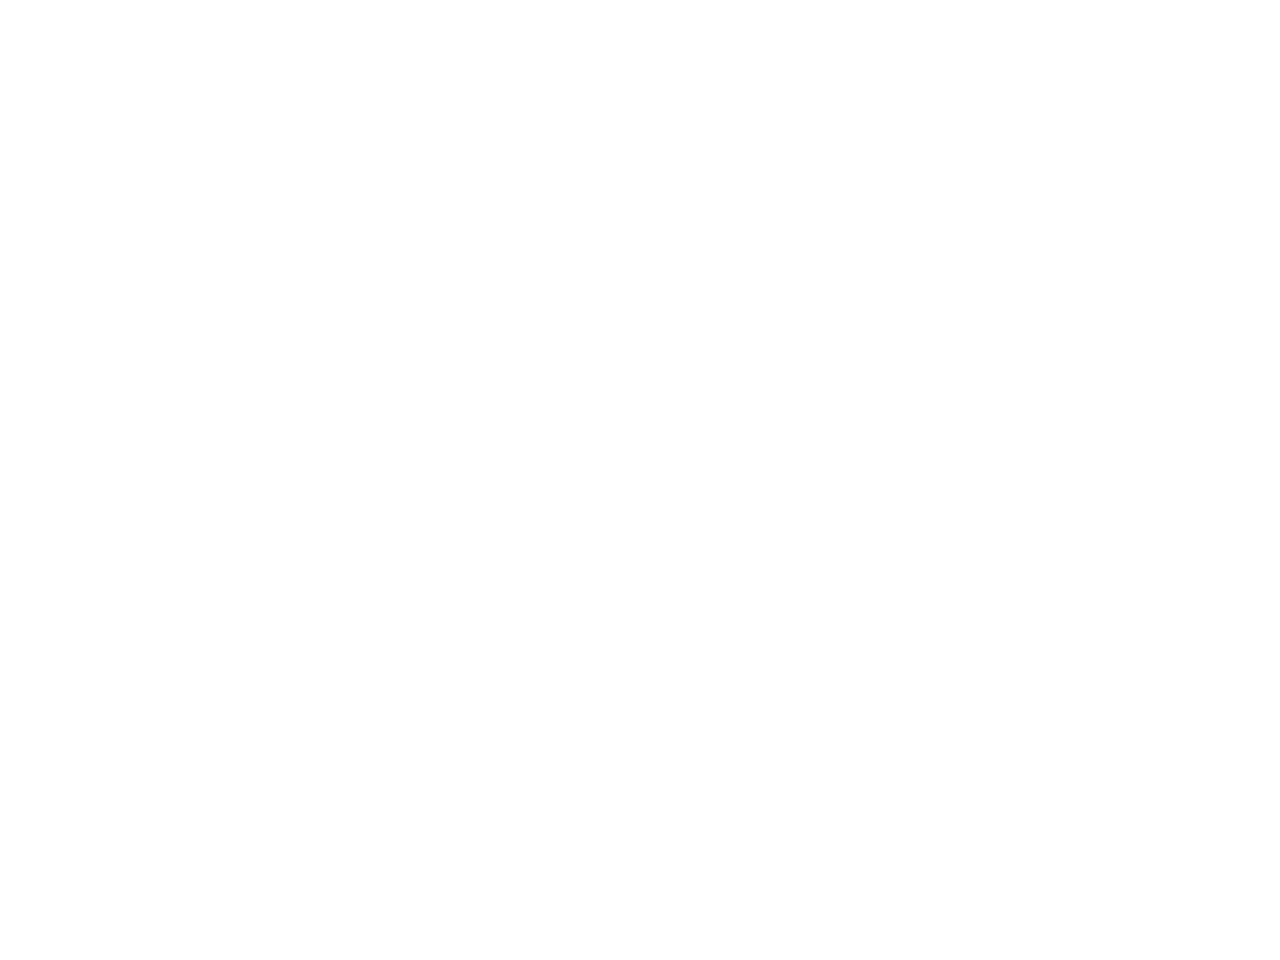

<IPython.core.display.Javascript object>


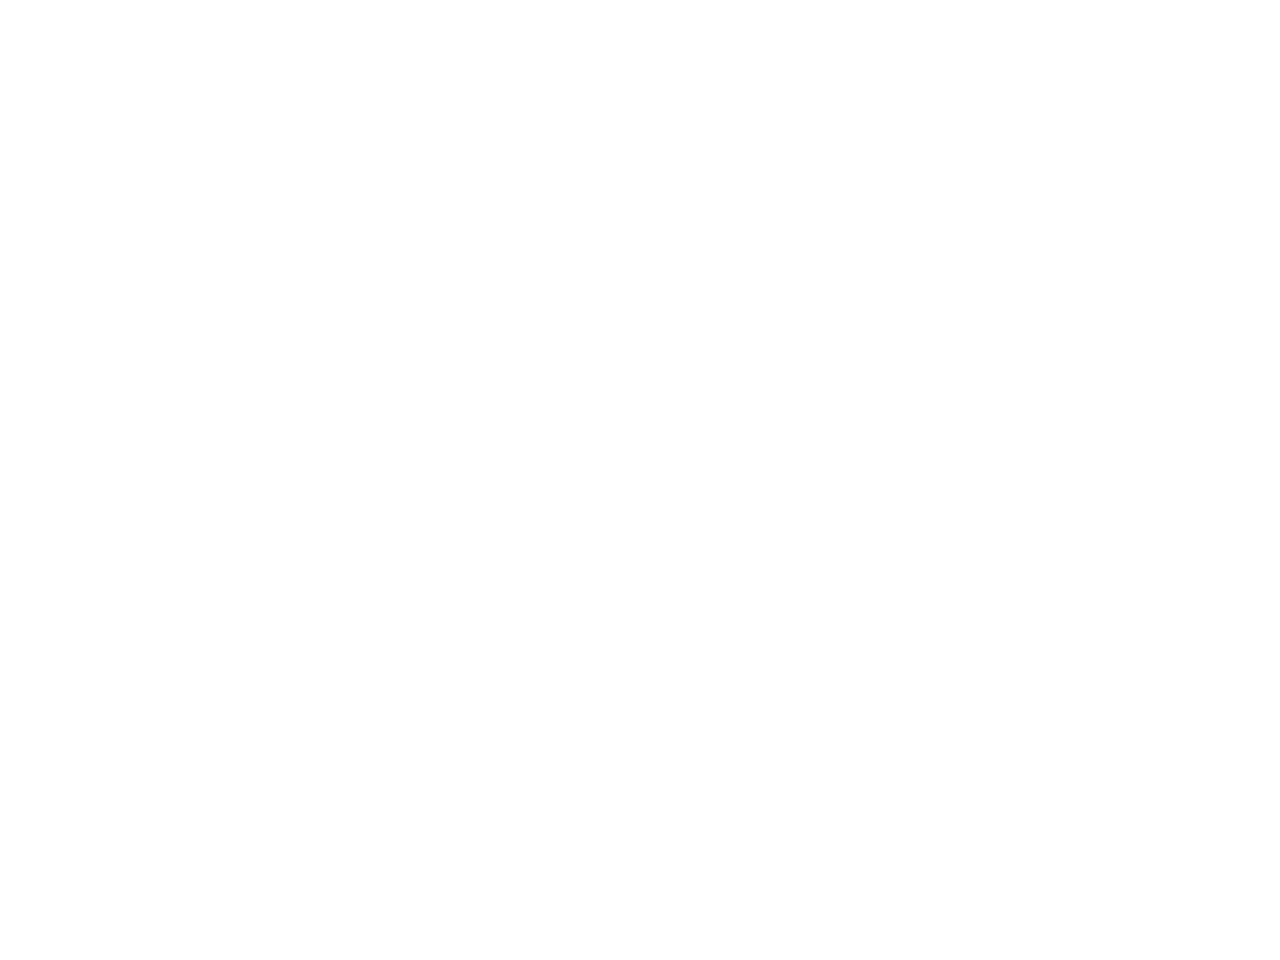

In [17]:
profile = ProfileReport(admissiondx, title="Pandas Profiling Report")
profile.to_file('admissiondx.html')

In [ ]:
Xy2.to_csv('Xy.csv', index=False)

In [ ]:
Xy2[Xy2['label']==1].shape[0]

In [ ]:
455/148455

In [ ]:
profile = ProfileReport(apachepredvar, title="Pandas Profiling Report")

In [ ]:
#profile.to_file('apachepredvar_cleaned.html')

In [ ]:
#profile.to_file('apachepredvar.html')

In [ ]:
# 